<a href="https://colab.research.google.com/github/kthanikonda/Privacy-Aware-Computing/blob/main/privacy_policies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install requests beautifulsoup4 pandas python-datefinder

ERROR: Could not find a version that satisfies the requirement python-datefinder (from versions: none)
ERROR: No matching distribution found for python-datefinder


In [ ]:
! pip install datefinder


In [ ]:
! pip install requests beautifulsoup4 pandas python-datefinder

ERROR: Could not find a version that satisfies the requirement python-datefinder (from versions: none)
ERROR: No matching distribution found for python-datefinder


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
from IPython.core.display import HTML
import datefinder

# List of companies and their current privacy policy URLs
privacy_policies = {
    "Google": "https://policies.google.com/privacy",
    "Twitter": "https://twitter.com/en/privacy",
    "Microsoft": "https://privacy.microsoft.com/en-us/privacystatement",
    "LinkedIn": "https://www.linkedin.com/legal/privacy-policy",
    "Netflix": "https://help.netflix.com/legal/privacy"
}

# Function to fetch snapshots from specific years (2018 and 2020)
def fetch_specific_year_snapshots(url, year, max_retries=3, timeout=15):
    api_url = "https://web.archive.org/cdx/search/cdx"
    params = {
        "url": url,
        "output": "json",
        "from": f"{year}0101",  # Start of the year
        "to": f"{year}1231",    # End of the year
        "limit": 1,             # Fetch only the first snapshot of the year
    }
    retries = 0
    while retries < max_retries:
        try:
            response = requests.get(api_url, params=params, timeout=timeout)
            response.raise_for_status()
            snapshots = response.json()

            if len(snapshots) <= 1:
                print(f"No snapshots found for {url} in {year}.")
                return None

            snapshot = snapshots[1]  # First result (skip header row)

            # Format date to 'YYYY-MM-DD'
            def format_date(timestamp):
                return datetime.strptime(timestamp, "%Y%m%d%H%M%S").strftime("%Y-%m-%d")

            return {"date": format_date(snapshot[1]), "url": f"https://web.archive.org/web/{snapshot[1]}/{url}"}
        except requests.exceptions.Timeout:
            retries += 1
            print(f"Timeout occurred for {url} in {year}. Retrying {retries}/{max_retries}...")
        except Exception as e:
            print(f"Error fetching snapshot for {url} in {year}: {e}")
            return None

    print(f"Failed to fetch snapshot for {url} in {year} after {max_retries} retries.")
    return None

# Function to fetch the last update date for the current policy
def fetch_last_modified_date(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
        "Accept-Encoding": "gzip, deflate",  # Avoid Zstandard compression
        "Accept-Language": "en-US,en;q=0.9",
        "Connection": "keep-alive"
    }
    try:
        response = requests.get(url, headers=headers, timeout=10)  # Full GET request to fetch page content
        response.raise_for_status()

        # Use BeautifulSoup to parse the HTML
        soup = BeautifulSoup(response.text, "html.parser")
        today = datetime.now().date()

        # Search for keywords like "Effective" or "Last Updated" in the HTML content
        keywords = ["effective", "last updated", "updated on", "last modified"]
        for keyword in keywords:
            for element in soup.find_all(string=True):  # Updated to string=True
                if keyword in element.lower():
                    # Attempt to extract a date near the keyword
                    try:
                        possible_dates = list(datefinder.find_dates(element))
                        if possible_dates:
                            date = possible_dates[0]
                            if 2000 <= date.year <= today.year:  # Validate realistic date
                                return date.strftime("%Y-%m-%d")
                    except Exception:
                        continue

        # Fallback to 'Last-Modified' header if date not found in content
        last_modified = response.headers.get("Last-Modified")
        if last_modified:
            try:
                date = datetime.strptime(last_modified, "%a, %d %b %Y %H:%M:%S %Z")
                if 2000 <= date.year <= today.year:  # Validate realistic date
                    return date.strftime("%Y-%m-%d")
            except Exception:
                pass

        print(f"  No effective date or 'Last-Modified' header found for {url}. Using today's date.")
        return today.strftime("%Y-%m-%d")  # Fallback to today's date
    except Exception as e:
        print(f"Error fetching last updated date for {url}: {e}")
        return today.strftime("%Y-%m-%d")  # Fallback to today's date

# Collect data
data = []

# Process each company
for company, url in privacy_policies.items():
    print(f"\nProcessing: {company}")

    # Fetch last update date for current policy
    last_modified_date = fetch_last_modified_date(url)
    data.append({
        "Company": company,
        "URL": url,
        "Date": last_modified_date,
        "Source": "Current Website",
        "Notes": "Latest privacy policy"
    })
    print(f"  Added current URL for {company}: {url} (Last Updated: {last_modified_date})")

    # Fetch snapshots for 2018
    snapshot_2018 = fetch_specific_year_snapshots(url, 2018)
    if snapshot_2018:
        data.append({
            "Company": company,
            "URL": snapshot_2018["url"],
            "Date": snapshot_2018["date"],
            "Source": "Wayback Machine",
            "Notes": "Snapshot from 2018"
        })
        print(f"  Added snapshot URL (2018): {snapshot_2018['url']} (Date: {snapshot_2018['date']})")

    # Fetch snapshots for 2020
    snapshot_2020 = fetch_specific_year_snapshots(url, 2020)
    if snapshot_2020:
        data.append({
            "Company": company,
            "URL": snapshot_2020["url"],
            "Date": snapshot_2020["date"],
            "Source": "Wayback Machine",
            "Notes": "Snapshot from 2020"
        })
        print(f"  Added snapshot URL (2020): {snapshot_2020['url']} (Date: {snapshot_2020['date']})")

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Company", "URL", "Date", "Source", "Notes"])

# Adjust pandas settings
pd.set_option('display.max_colwidth', None)  # Show full content in each column

# Save to CSV
output_path = "privacy_policies_snapshots.csv"
df.to_csv(output_path, index=False)
print(f"\nData saved to: {output_path}")

# Display full DataFrame
print("\nFull DataFrame:")
print(df.to_string(index=False))

# Optionally, display as HTML in Jupyter Notebook
display(HTML(df.to_html(index=False)))



Processing: Google
  Added current URL for Google: https://policies.google.com/privacy (Last Updated: 2024-09-16)
  Added snapshot URL (2018): https://web.archive.org/web/20180323144049/https://policies.google.com/privacy (Date: 2018-03-23)
  Added snapshot URL (2020): https://web.archive.org/web/20200101000943/https://policies.google.com/privacy (Date: 2020-01-01)

Processing: Twitter
  Added current URL for Twitter: https://twitter.com/en/privacy (Last Updated: 2024-11-15)
  Added snapshot URL (2018): https://web.archive.org/web/20180101012521/https://twitter.com/en/privacy (Date: 2018-01-01)
  Added snapshot URL (2020): https://web.archive.org/web/20200101000045/https://twitter.com/en/privacy (Date: 2020-01-01)

Processing: Microsoft
  Added current URL for Microsoft: https://privacy.microsoft.com/en-us/privacystatement (Last Updated: 2024-11-28)
  Added snapshot URL (2018): https://web.archive.org/web/20180101165215/https://privacy.microsoft.com/en-us/privacystatement (Date: 2018-

Company,URL,Date,Source,Notes
Google,https://policies.google.com/privacy,2024-09-16,Current Website,Latest privacy policy
Google,https://web.archive.org/web/20180323144049/https://policies.google.com/privacy,2018-03-23,Wayback Machine,Snapshot from 2018
Google,https://web.archive.org/web/20200101000943/https://policies.google.com/privacy,2020-01-01,Wayback Machine,Snapshot from 2020
Twitter,https://twitter.com/en/privacy,2024-11-15,Current Website,Latest privacy policy
Twitter,https://web.archive.org/web/20180101012521/https://twitter.com/en/privacy,2018-01-01,Wayback Machine,Snapshot from 2018
Twitter,https://web.archive.org/web/20200101000045/https://twitter.com/en/privacy,2020-01-01,Wayback Machine,Snapshot from 2020
Microsoft,https://privacy.microsoft.com/en-us/privacystatement,2024-11-28,Current Website,Latest privacy policy
Microsoft,https://web.archive.org/web/20180101165215/https://privacy.microsoft.com/en-us/privacystatement,2018-01-01,Wayback Machine,Snapshot from 2018
Microsoft,https://web.archive.org/web/20200101000329/https://privacy.microsoft.com/en-us/privacystatement,2020-01-01,Wayback Machine,Snapshot from 2020
LinkedIn,https://www.linkedin.com/legal/privacy-policy,2024-09-18,Current Website,Latest privacy policy


In [ ]:
import requests
import time
from bs4 import BeautifulSoup
import re
from collections import Counter

# URLs for Netflix privacy policies
urls = [
    "https://help.netflix.com/legal/privacy",  # Current policy
    "https://web.archive.org/web/20180123034715/https://help.netflix.com/legal/privacy",  # 2018 policy
    "https://web.archive.org/web/20200101104405/https://help.netflix.com/legal/privacy"  # 2020 policy
]

# Function to fetch and parse content
def fetch_policy_content(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")
        # Extract visible text
        policy_text = soup.get_text(separator=' ')
        return policy_text.strip()
    except requests.RequestException as e:
        print(f"Error fetching URL {url}: {e}")
        return None

# Fetch policies and store content
policy_texts = []
for url in urls:
    print(f"Fetching: {url}")
    text = fetch_policy_content(url)
    if text:
        policy_texts.append(text)
    time.sleep(3)  # Polite delay

# Save the content and perform content analysis
for i, text in enumerate(policy_texts):
    filename = f"netflix_policy_{i+1}.txt"
    with open(filename, "w", encoding="utf-8") as file:
        file.write(text)
        print(f"Saved policy content to {filename}")

# Analysis Functions
def analyze_text(text):
    # Word count
    word_count = len(re.findall(r"\w+", text))

    # Sentence count and average sentence length
    sentences = re.split(r'[.!?]', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    avg_sentence_length = sum(len(s.split()) for s in sentences) / len(sentences) if sentences else 0

    # Keyword frequency analysis
    keywords = ["data", "user", "third party", "consent", "retention"]
    word_freq = Counter(text.lower().split())
    keyword_counts = {keyword: word_freq[keyword] for keyword in keywords}

    # Section count (based on typical headings)
    sections = len(re.findall(r"(?m)^\s*[A-Z][\w\s]+:$", text))

    return {
        "Total Words": word_count,
        "Average Sentence Length": avg_sentence_length,
        "Keyword Frequency": keyword_counts,
        "Section Count": sections
    }

# Policy comparison for updates
def compare_policies(text1, text2):
    set1 = set(text1.split())
    set2 = set(text2.split())
    added = set2 - set1
    removed = set1 - set2
    return {
        "Added Words": added,
        "Removed Words": removed
    }

# Display analysis results
for i, text in enumerate(policy_texts):
    print(f"\n--- Analysis for Netflix Policy {i + 1} ---")
    analysis = analyze_text(text)
    for key, value in analysis.items():
        print(f"{key}: {value}")

# Policy updates comparison
if len(policy_texts) >= 2:
    print("\n--- Policy Updates Between First and Last Snapshot ---")
    changes = compare_policies(policy_texts[0], policy_texts[-1])
    print("Added Words:", changes["Added Words"])
    print("Removed Words:", changes["Removed Words"])


Fetching: https://help.netflix.com/legal/privacy
Error fetching URL https://help.netflix.com/legal/privacy: ('Received response with content-encoding: zstd, but failed to decode it.', ZstdError('cannot use a decompressobj multiple times'))
Fetching: https://web.archive.org/web/20180123034715/https://help.netflix.com/legal/privacy
Fetching: https://web.archive.org/web/20200101104405/https://help.netflix.com/legal/privacy
Saved policy content to netflix_policy_1.txt
Saved policy content to netflix_policy_2.txt

--- Analysis for Netflix Policy 1 ---
Total Words: 3063
Average Sentence Length: 26.780701754385966
Keyword Frequency: {'data': 12, 'user': 2, 'third party': 0, 'consent': 0, 'retention': 0}
Section Count: 0

--- Analysis for Netflix Policy 2 ---
Total Words: 5617
Average Sentence Length: 28.464285714285715
Keyword Frequency: {'data': 18, 'user': 7, 'third party': 0, 'consent': 0, 'retention': 0}
Section Count: 2

--- Policy Updates Between First and Last Snapshot ---
Added Words:

In [ ]:
import requests
import time
import re
from bs4 import BeautifulSoup
from collections import Counter
import pandas as pd

# URLs for Netflix privacy policies
urls = [
    "https://help.netflix.com/legal/privacy",
    "https://web.archive.org/web/20180123034715/https://help.netflix.com/legal/privacy",
    "https://web.archive.org/web/20200101104405/https://help.netflix.com/legal/privacy"
]

def fetch_policy_content(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")
        policy_text = soup.get_text(separator=' ')
        return policy_text.strip()
    except requests.RequestException as e:
        print(f"Error fetching URL {url}: {e}")
        return None

def analyze_text(text):
    word_count = len(re.findall(r"\w+", text))
    sentences = re.split(r'[.!?]', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    avg_sentence_length = sum(len(s.split()) for s in sentences) / len(sentences) if sentences else 0
    keywords = ["data", "user", "third party", "consent", "retention"]
    word_freq = Counter(text.lower().split())
    keyword_counts = {keyword: word_freq[keyword] for keyword in keywords}
    return {
        "Word Count": word_count,
        "Average Sentence Length": avg_sentence_length,
        **keyword_counts
    }

# Fetch and analyze policies
data_records = []
for i, url in enumerate(urls):
    print(f"Fetching: {url}")
    text = fetch_policy_content(url)
    time.sleep(3)
    if text:
        analysis = analyze_text(text)
        record = {"URL": url, **analysis}
        data_records.append(record)

# Save policy analysis to a CSV
df = pd.DataFrame(data_records)
csv_filename = "policy_analysis.csv"
df.to_csv(csv_filename, index=False, encoding="utf-8")
print(f"Policy analysis saved to {csv_filename}")


Fetching: https://help.netflix.com/legal/privacy
Error fetching URL https://help.netflix.com/legal/privacy: ('Received response with content-encoding: zstd, but failed to decode it.', ZstdError('cannot use a decompressobj multiple times'))
Fetching: https://web.archive.org/web/20180123034715/https://help.netflix.com/legal/privacy
Fetching: https://web.archive.org/web/20200101104405/https://help.netflix.com/legal/privacy
Policy analysis saved to policy_analysis.csv


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import datetime
from collections import Counter
import textstat
from difflib import Differ

# List of companies and their current privacy policy URLs
privacy_policies = {
    "Google": "https://policies.google.com/privacy",
    "Twitter": "https://twitter.com/en/privacy",
    "Microsoft": "https://privacy.microsoft.com/en-us/privacystatement",
    "LinkedIn": "https://www.linkedin.com/legal/privacy-policy",
    "Netflix": "https://help.netflix.com/legal/privacy"
}

# Function to fetch snapshots from specific years (2018 and 2020)
def fetch_specific_year_snapshots(url, year, max_retries=3, timeout=15):
    api_url = "https://web.archive.org/cdx/search/cdx"
    params = {
        "url": url,
        "output": "json",
        "from": f"{year}0101",
        "to": f"{year}1231",
        "limit": 1,
    }
    retries = 0
    while retries < max_retries:
        try:
            response = requests.get(api_url, params=params, timeout=timeout)
            response.raise_for_status()
            snapshots = response.json()
            if len(snapshots) <= 1:
                return None
            snapshot = snapshots[1]
            return {"date": snapshot[1][:8], "url": f"https://web.archive.org/web/{snapshot[1]}/{url}"}
        except requests.exceptions.Timeout:
            retries += 1
        except Exception:
            return None
    return None

# Function to fetch privacy policy text
def fetch_policy_text(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        return ' '.join(soup.stripped_strings)
    except Exception:
        return ""

# Function to analyze text
def analyze_text(text):
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    headings = [h.get_text() for h in BeautifulSoup(text, "html.parser").find_all(['h1', 'h2', 'h3'])]

    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    keyword_counts = Counter({kw: text.lower().count(kw) for kw in keywords})

    return {
        "word_count": len(words),
        "avg_sentence_length": sum(len(s.split()) for s in sentences if s) / max(len(sentences), 1),
        "section_count": len(headings),
        "keyword_frequency": keyword_counts
    }

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Dale-Chall Readability": textstat.dale_chall_readability_score(text),
        "Complex Words Percentage": textstat.difficult_words(text) / max(len(text.split()), 1) * 100
    }

# Function to compare old and new policy versions
def compare_policies(old_text, new_text):
    differ = Differ()
    old_lines = old_text.split("\n")
    new_lines = new_text.split("\n")
    diff = list(differ.compare(old_lines, new_lines))

    added = [line[2:] for line in diff if line.startswith('+ ')]
    removed = [line[2:] for line in diff if line.startswith('- ')]

    return {
        "Added Sections": len(added),
        "Removed Sections": len(removed),
        "Modified Sections": len(set(added) & set(removed))  # Overlapping changes
    }

# Collect data
data = []

for company, url in privacy_policies.items():
    text_current = fetch_policy_text(url)
    analysis_current = analyze_text(text_current)
    readability_current = readability_analysis(text_current)

    data.append({
        "Company": company,
        "URL": url,
        "Word Count": analysis_current["word_count"],
        "Avg Sentence Length": analysis_current["avg_sentence_length"],
        "Section Count": analysis_current["section_count"],
        "Keyword Frequency": analysis_current["keyword_frequency"],
        "Flesch Reading Ease": readability_current["Flesch Reading Ease"],
        "Gunning Fog Index": readability_current["Gunning Fog Index"],
        "SMOG Index": readability_current["SMOG Index"],
        "Complex Words %": readability_current["Complex Words Percentage"],
        "Source": "Current Website",
        "Notes": "Latest privacy policy"
    })

    for year in [2018, 2020]:
        snapshot = fetch_specific_year_snapshots(url, year)
        if snapshot:
            text_old = fetch_policy_text(snapshot["url"])
            analysis_old = analyze_text(text_old)
            readability_old = readability_analysis(text_old)
            policy_changes = compare_policies(text_old, text_current)

            data.append({
                "Company": company,
                "URL": snapshot["url"],
                "Word Count": analysis_old["word_count"],
                "Avg Sentence Length": analysis_old["avg_sentence_length"],
                "Section Count": analysis_old["section_count"],
                "Keyword Frequency": analysis_old["keyword_frequency"],
                "Flesch Reading Ease": readability_old["Flesch Reading Ease"],
                "Gunning Fog Index": readability_old["Gunning Fog Index"],
                "SMOG Index": readability_old["SMOG Index"],
                "Complex Words %": readability_old["Complex Words Percentage"],
                "Added Sections": policy_changes["Added Sections"],
                "Removed Sections": policy_changes["Removed Sections"],
                "Modified Sections": policy_changes["Modified Sections"],
                "Source": "Wayback Machine",
                "Notes": f"Snapshot from {year}"
            })

# Convert to DataFrame
df = pd.DataFrame(data)

# Save results
df.to_csv("privacy_policy_analysis.csv", index=False)

# Display DataFrame
from IPython.display import display
display(df)


,Company,URL,Word Count,Avg Sentence Length,Section Count,Keyword Frequency,Flesch Reading Ease,Gunning Fog Index,SMOG Index,Complex Words %,Source,Notes
0,Google,https://policies.google.com/privacy,10369,24.388626,0,"{'data': 79, 'user': 27, 'third party': 4, 'co...",45.59,11.72,14.4,7.598372,Current Website,Latest privacy policy
1,Twitter,https://twitter.com/en/privacy,5734,19.037162,0,"{'data': 37, 'user': 16, 'third party': 1, 'co...",48.84,11.13,14.0,9.903812,Current Website,Latest privacy policy
2,Microsoft,https://privacy.microsoft.com/en-us/privacysta...,0,0.000000,0,"{'data': 0, 'user': 0, 'third party': 0, 'cons...",206.84,0.00,0.0,0.000000,Current Website,Latest privacy policy
3,LinkedIn,https://www.linkedin.com/legal/privacy-policy,7128,16.895981,0,"{'data': 142, 'user': 17, 'third party': 0, 'c...",49.75,10.42,13.2,9.404745,Current Website,Latest privacy policy
4,Netflix,https://help.netflix.com/legal/privacy,0,0.000000,0,"{'data': 0, 'user': 0, 'third party': 0, 'cons...",206.84,0.00,0.0,0.000000,Current Website,Latest privacy policy


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import datetime
from collections import Counter
import textstat
from difflib import Differ

# List of companies and their current privacy policy URLs
privacy_policies = {
    "Google": "https://policies.google.com/privacy",
    "Twitter": "https://twitter.com/en/privacy",
    "Microsoft": "https://privacy.microsoft.com/en-us/privacystatement",
    "LinkedIn": "https://www.linkedin.com/legal/privacy-policy",
    "Netflix": "https://help.netflix.com/legal/privacy"
}

# Function to fetch snapshots from specific years (2018 and 2020)
def fetch_specific_year_snapshots(url, year, max_retries=3, timeout=15):
    api_url = "https://web.archive.org/cdx/search/cdx"
    params = {
        "url": url,
        "output": "json",
        "from": f"{year}0101",
        "to": f"{year}1231",
        "limit": 1,
    }
    retries = 0
    while retries < max_retries:
        try:
            response = requests.get(api_url, params=params, timeout=timeout)
            response.raise_for_status()
            snapshots = response.json()
            if len(snapshots) <= 1:
                return None
            snapshot = snapshots[1]
            return {"date": snapshot[1][:8], "url": f"https://web.archive.org/web/{snapshot[1]}/{url}"}
        except requests.exceptions.Timeout:
            retries += 1
        except Exception:
            return None
    return None

# Function to fetch privacy policy text
def fetch_policy_text(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        return ' '.join(soup.stripped_strings)
    except Exception:
        return ""

# Function to analyze text
def analyze_text(text):
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    headings = [h.get_text() for h in BeautifulSoup(text, "html.parser").find_all(['h1', 'h2', 'h3'])]

    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    keyword_counts = Counter({kw: text.lower().count(kw) for kw in keywords})

    return {
        "word_count": len(words),
        "avg_sentence_length": sum(len(s.split()) for s in sentences if s) / max(len(sentences), 1),
        "section_count": len(headings),
        "keyword_frequency": keyword_counts
    }

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Dale-Chall Readability": textstat.dale_chall_readability_score(text),
        "Complex Words Percentage": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to compare old and new policy versions
def compare_policies(old_text, new_text):
    differ = Differ()
    old_lines = old_text.split("\n")
    new_lines = new_text.split("\n")
    diff = list(differ.compare(old_lines, new_lines))

    added = [line[2:] for line in diff if line.startswith('+ ')]
    removed = [line[2:] for line in diff if line.startswith('- ')]

    return {
        "Added Sections": len(added),
        "Removed Sections": len(removed),
        "Modified Sections": len(set(added) & set(removed))  # Overlapping changes
    }

# Collect data
data = []

for company, url in privacy_policies.items():
    print(f"Processing {company}...")

    text_current = fetch_policy_text(url)
    analysis_current = analyze_text(text_current)
    readability_current = readability_analysis(text_current)

    data.append({
        "Company": company,
        "URL": url,
        "Word Count": analysis_current["word_count"],
        "Avg Sentence Length": analysis_current["avg_sentence_length"],
        "Section Count": analysis_current["section_count"],
        "Keyword Frequency": analysis_current["keyword_frequency"],
        "Flesch Reading Ease": readability_current["Flesch Reading Ease"],
        "Gunning Fog Index": readability_current["Gunning Fog Index"],
        "SMOG Index": readability_current["SMOG Index"],
        "Complex Words %": readability_current["Complex Words Percentage"],
        "Source": "Current Website",
        "Notes": "Latest privacy policy"
    })

    for year in [2018, 2020]:
        snapshot = fetch_specific_year_snapshots(url, year)
        if snapshot:
            print(f"Fetching archived version for {company} ({year})...")
            text_old = fetch_policy_text(snapshot["url"])
            analysis_old = analyze_text(text_old)
            readability_old = readability_analysis(text_old)
            policy_changes = compare_policies(text_old, text_current)

            data.append({
                "Company": company,
                "URL": snapshot["url"],
                "Word Count": analysis_old["word_count"],
                "Avg Sentence Length": analysis_old["avg_sentence_length"],
                "Section Count": analysis_old["section_count"],
                "Keyword Frequency": analysis_old["keyword_frequency"],
                "Flesch Reading Ease": readability_old["Flesch Reading Ease"],
                "Gunning Fog Index": readability_old["Gunning Fog Index"],
                "SMOG Index": readability_old["SMOG Index"],
                "Complex Words %": readability_old["Complex Words Percentage"],
                "Added Sections": policy_changes["Added Sections"],
                "Removed Sections": policy_changes["Removed Sections"],
                "Modified Sections": policy_changes["Modified Sections"],
                "Source": "Wayback Machine",
                "Notes": f"Snapshot from {year}"
            })

# Convert to DataFrame
df = pd.DataFrame(data)

# Save results
df.to_csv("privacy_policy_analysis.csv", index=False)

# Display DataFrame
from IPython.display import display
display(df)


Processing Google...
Fetching archived version for Google (2018)...
Fetching archived version for Google (2020)...
Processing Twitter...
Fetching archived version for Twitter (2018)...
Fetching archived version for Twitter (2020)...
Processing Microsoft...
Fetching archived version for Microsoft (2018)...
Fetching archived version for Microsoft (2020)...
Processing LinkedIn...
Fetching archived version for LinkedIn (2018)...
Fetching archived version for LinkedIn (2020)...
Processing Netflix...
Fetching archived version for Netflix (2018)...


,Company,URL,Word Count,Avg Sentence Length,Section Count,Keyword Frequency,Flesch Reading Ease,Gunning Fog Index,SMOG Index,Complex Words %,Source,Notes,Added Sections,Removed Sections,Modified Sections
0,Google,https://policies.google.com/privacy,10369,24.388626,0,"{'data': 79, 'user': 27, 'third party': 4, 'co...",45.59,11.72,14.4,7.598372,Current Website,Latest privacy policy,NaN,NaN,NaN
1,Google,https://web.archive.org/web/20180323144049/htt...,967,693.000000,0,"{'data': 0, 'user': 0, 'third party': 0, 'cons...",-578.80,270.31,0.0,4.761905,Wayback Machine,Snapshot from 2018,1.0,1.0,0.0
2,Google,https://web.archive.org/web/20200101000943/htt...,8097,24.217523,0,"{'data': 56, 'user': 22, 'third party': 0, 'co...",46.10,11.71,14.5,8.477746,Wayback Machine,Snapshot from 2020,1.0,1.0,0.0
3,Twitter,https://twitter.com/en/privacy,5734,19.037162,0,"{'data': 37, 'user': 16, 'third party': 1, 'co...",48.84,11.13,14.0,9.903812,Current Website,Latest privacy policy,NaN,NaN,NaN
4,Twitter,https://web.archive.org/web/20180101012521/htt...,4012,23.598802,0,"{'data': 31, 'user': 27, 'third party': 1, 'co...",45.09,12.67,14.7,10.924797,Wayback Machine,Snapshot from 2018,3.0,1.0,0.0
5,Twitter,https://web.archive.org/web/20200101000045/htt...,11807,22.816901,0,"{'data': 166, 'user': 12, 'third party': 2, 'c...",45.59,11.25,14.3,4.913831,Wayback Machine,Snapshot from 2020,3.0,1.0,0.0
6,Microsoft,https://privacy.microsoft.com/en-us/privacysta...,0,0.000000,0,"{'data': 0, 'user': 0, 'third party': 0, 'cons...",206.84,0.00,0.0,0.000000,Current Website,Latest privacy policy,NaN,NaN,NaN
7,Microsoft,https://web.archive.org/web/20180101165215/htt...,26388,19.209010,0,"{'data': 518, 'user': 51, 'third party': 10, '...",40.69,9.93,13.7,5.407689,Wayback Machine,Snapshot from 2018,1.0,3.0,0.0
8,Microsoft,https://web.archive.org/web/20200101000329/htt...,35515,20.632353,0,"{'data': 785, 'user': 92, 'third party': 16, '...",40.08,10.03,14.1,4.592256,Wayback Machine,Snapshot from 2020,1.0,12.0,0.0
9,LinkedIn,https://www.linkedin.com/legal/privacy-policy,7128,16.895981,0,"{'data': 142, 'user': 17, 'third party': 0, 'c...",49.75,10.42,13.2,9.404745,Current Website,Latest privacy policy,NaN,NaN,NaN


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import datetime
from collections import Counter
from difflib import Differ
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time

# List of companies and their current privacy policy URLs
privacy_policies = {
    "Google": "https://policies.google.com/privacy",
    "Twitter": "https://twitter.com/en/privacy",
    "Microsoft": "https://privacy.microsoft.com/en-us/privacystatement",
    "LinkedIn": "https://www.linkedin.com/legal/privacy-policy",
    "Netflix": "https://help.netflix.com/legal/privacy"
}

# Function to fetch privacy policy text with Selenium to handle dynamic content
def fetch_policy_text(url):
    options = Options()
    options.add_argument("--headless")  # Run Chrome in headless mode
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-popup-blocking")  # Prevent pop-ups
    options.add_argument("--disable-blink-features=AutomationControlled")  # Hide Selenium usage
    options.add_argument("--disable-features=PreloadMediaEngagementData, MediaEngagementBypassAutoplayPolicies")
    options.add_argument("--disable-infobars")  # Remove automation detection
    options.add_argument("--disable-extensions")  # Disable Chrome extensions
    options.add_argument("--remote-debugging-port=9222")  # Open debugging port
    options.binary_location = "/usr/bin/google-chrome-stable"

    service = Service("/usr/local/bin/chromedriver")
    driver = webdriver.Chrome(service=service, options=options)

    try:
        # Hide Selenium automation detection
        driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", {
            "source": "Object.defineProperty(navigator, 'webdriver', {get: () => undefined})"
        })

        driver.get(url)
        time.sleep(5)  # Allow JavaScript to load

        # Scroll to the bottom to load full content
        last_height = driver.execute_script("return document.body.scrollHeight")
        while True:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height

        text = driver.find_element("tag name", "body").text
        return text
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return ""
    finally:
        driver.quit()

# Function to analyze text
def analyze_text(text):
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    keyword_counts = Counter({kw: text.lower().count(kw) for kw in keywords})
    return {
        "word_count": len(words),
        "avg_sentence_length": sum(len(s.split()) for s in sentences if s) / max(len(sentences), 1),
        "keyword_frequency": keyword_counts
    }

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to calculate deception score
def calculate_deception_score(text):
    readability = readability_analysis(text)
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)
    deception_score = (
        (100 - readability["Flesch Reading Ease"]) +
        readability["Gunning Fog Index"] +
        readability["Complex Words %"] +
        vague_word_count
    ) / 4  # Normalize the score
    return deception_score

# Function to compare changes in deception score
def compare_deception_scores(original_text, modified_text):
    original_score = calculate_deception_score(original_text)
    modified_score = calculate_deception_score(modified_text)
    score_difference = modified_score - original_score
    return {
        "Original Score": original_score,
        "Modified Score": modified_score,
        "Difference": score_difference
    }

# Collect data
data = []

for company, url in privacy_policies.items():
    print(f"Processing {company}...")
    text_current = fetch_policy_text(url)
    if not text_current:
        print(f"Could not fetch privacy policy for {company}")
    analysis_current = analyze_text(text_current)
    readability_current = readability_analysis(text_current)
    deception_score = calculate_deception_score(text_current)

    data.append({
        "Company": company,
        "URL": url,
        "Privacy Policy": text_current,  # Store full text
        "Word Count": analysis_current["word_count"],
        "Avg Sentence Length": analysis_current["avg_sentence_length"],
        "Keyword Frequency": analysis_current["keyword_frequency"],
        "Flesch Reading Ease": readability_current["Flesch Reading Ease"],
        "Gunning Fog Index": readability_current["Gunning Fog Index"],
        "SMOG Index": readability_current["SMOG Index"],
        "Complex Words %": readability_current["Complex Words %"],
        "Deception Score": deception_score,
        "Source": "Current Website"
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Save results
df.to_csv("privacy_policy_analysis.csv", index=False)

# Display DataFrame
from IPython.display import display
display(df)


ModuleNotFoundError: No module named 'selenium'

In [ ]:
! pip install selenium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.3/486.3 kB 21.2 MB/s eta 0:00:00


In [ ]:
!apt-get update
!apt install -y chromium-chromedriver
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import datetime
from collections import Counter
from difflib import Differ
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time

# List of companies and their current privacy policy URLs
privacy_policies = {
    "Google": "https://policies.google.com/privacy",
    "Twitter": "https://twitter.com/en/privacy",
    "Microsoft": "https://privacy.microsoft.com/en-us/privacystatement",
    "LinkedIn": "https://www.linkedin.com/legal/privacy-policy",
    "Netflix": "https://help.netflix.com/legal/privacy"
}

# Function to fetch privacy policy text with Selenium to handle dynamic content
def fetch_policy_text(url):
    options = Options()
    options.add_argument("--headless")  # Run Chrome in headless mode
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-popup-blocking")  # Prevent pop-ups
    options.add_argument("--disable-blink-features=AutomationControlled")  # Hide Selenium usage
    options.add_argument("--disable-features=PreloadMediaEngagementData, MediaEngagementBypassAutoplayPolicies")
    options.add_argument("--disable-infobars")  # Remove automation detection
    options.add_argument("--disable-extensions")  # Disable Chrome extensions
    options.add_argument("--remote-debugging-port=9222")  # Open debugging port
    options.binary_location = "/usr/bin/google-chrome-stable"

    service = Service("/usr/local/bin/chromedriver")
    driver = webdriver.Chrome(service=service, options=options)

    try:
        # Hide Selenium automation detection
        driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", {
            "source": "Object.defineProperty(navigator, 'webdriver', {get: () => undefined})"
        })

        driver.get(url)
        time.sleep(5)  # Allow JavaScript to load

        # Scroll to the bottom to load full content
        last_height = driver.execute_script("return document.body.scrollHeight")
        while True:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height

        text = driver.find_element("tag name", "body").text
        return text
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return ""
    finally:
        driver.quit()

# Function to analyze text
def analyze_text(text):
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    keyword_counts = Counter({kw: text.lower().count(kw) for kw in keywords})
    return {
        "word_count": len(words),
        "avg_sentence_length": sum(len(s.split()) for s in sentences if s) / max(len(sentences), 1),
        "keyword_frequency": keyword_counts
    }

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to calculate deception score
def calculate_deception_score(text):
    readability = readability_analysis(text)
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)
    deception_score = (
        (100 - readability["Flesch Reading Ease"]) +
        readability["Gunning Fog Index"] +
        readability["Complex Words %"] +
        vague_word_count
    ) / 4  # Normalize the score
    return deception_score

# Function to compare changes in deception score
def compare_deception_scores(original_text, modified_text):
    original_score = calculate_deception_score(original_text)
    modified_score = calculate_deception_score(modified_text)
    score_difference = modified_score - original_score
    return {
        "Original Score": original_score,
        "Modified Score": modified_score,
        "Difference": score_difference
    }

# Collect data
data = []

for company, url in privacy_policies.items():
    print(f"Processing {company}...")
    text_current = fetch_policy_text(url)
    if not text_current:
        print(f"Could not fetch privacy policy for {company}")
    analysis_current = analyze_text(text_current)
    readability_current = readability_analysis(text_current)
    deception_score = calculate_deception_score(text_current)

    data.append({
        "Company": company,
        "URL": url,
        "Privacy Policy": text_current,  # Store full text
        "Word Count": analysis_current["word_count"],
        "Avg Sentence Length": analysis_current["avg_sentence_length"],
        "Keyword Frequency": analysis_current["keyword_frequency"],
        "Flesch Reading Ease": readability_current["Flesch Reading Ease"],
        "Gunning Fog Index": readability_current["Gunning Fog Index"],
        "SMOG Index": readability_current["SMOG Index"],
        "Complex Words %": readability_current["Complex Words %"],
        "Deception Score": deception_score,
        "Source": "Current Website"
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Save results
df.to_csv("privacy_policy_analysis.csv", index=False)

# Display DataFrame
from IPython.display import display
display(df)


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,311 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,230 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,606 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpad

NoSuchDriverException: Message: Unable to obtain driver for chrome; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors/driver_location


In [ ]:
# Install required Python packages
!pip install selenium textstat beautifulsoup4 pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.5 MB/s eta 0:00:00


In [ ]:
# Remove any previous versions of ChromeDriver
!rm /usr/local/bin/chromedriver

# Download the latest version of ChromeDriver
!wget https://storage.googleapis.com/chrome-for-testing-public/133.0.6943.53/linux64/chromedriver-linux64.zip
!unzip -o chromedriver-linux64.zip
!chmod +x chromedriver-linux64/chromedriver
!mv chromedriver-linux64/chromedriver /usr/local/bin/chromedriver

# Install Google Chrome
!apt-get update
!apt-get install -y google-chrome-stable

# Verify installations
!google-chrome --version
!chromedriver --version


rm: cannot remove '/usr/local/bin/chromedriver': No such file or directory
--2025-02-11 20:22:20--  https://storage.googleapis.com/chrome-for-testing-public/133.0.6943.53/linux64/chromedriver-linux64.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 74.125.143.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9456679 (9.0M) [application/zip]
Saving to: ‘chromedriver-linux64.zip’

chromedriver-linux6 100%[===================>]   9.02M  10.7MB/s    in 0.8s    

2025-02-11 20:22:21 (10.7 MB/s) - ‘chromedriver-linux64.zip’ saved [9456679/9456679]

Archive:  chromedriver-linux64.zip
  inflating: chromedriver-linux64/LICENSE.chromedriver  
  inflating: chromedriver-linux64/THIRD_PARTY_NOTICES.chromedriver  
  inflating: chromedriver-linux64/chromedriver  
Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cl

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import datetime
from collections import Counter
import textstat
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time

# List of companies and their current privacy policy URLs
privacy_policies = {
    "Google": "https://policies.google.com/privacy",
    "Twitter": "https://twitter.com/en/privacy",
    "Microsoft": "https://privacy.microsoft.com/en-us/privacystatement",
    "LinkedIn": "https://www.linkedin.com/legal/privacy-policy",
    "Netflix": "https://help.netflix.com/legal/privacy"
}

# Function to fetch privacy policy text using Selenium in Colab
def fetch_policy_text(url):
    options = Options()
    options.add_argument("--headless")  # Run Chrome in headless mode
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-gpu")  # Prevent GPU conflicts
    options.add_argument("--remote-debugging-port=9222")  # Enable debugging

    service = Service("/usr/local/bin/chromedriver")  # Correct path for Colab
    driver = webdriver.Chrome(service=service, options=options)

    try:
        driver.get(url)
        time.sleep(5)  # Allow JavaScript to load

        text = driver.find_element("tag name", "body").text
        return text
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return ""
    finally:
        driver.quit()


# Function to analyze text (word count, sentence structure, keywords)
def analyze_text(text):
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    keyword_counts = Counter({kw: text.lower().count(kw) for kw in keywords})
    return {
        "word_count": len(words),
        "avg_sentence_length": sum(len(s.split()) for s in sentences if s) / max(len(sentences), 1),
        "keyword_frequency": keyword_counts
    }

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to calculate deception score (measures vague and complex wording)
def calculate_deception_score(text):
    readability = readability_analysis(text)
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)
    deception_score = (
        (100 - readability["Flesch Reading Ease"]) +
        readability["Gunning Fog Index"] +
        readability["Complex Words %"] +
        vague_word_count
    ) / 4  # Normalize the score
    return deception_score

# Function to compare deception scores before and after changes
def compare_deception_scores(original_text, modified_text):
    original_score = calculate_deception_score(original_text)
    modified_score = calculate_deception_score(modified_text)
    score_difference = modified_score - original_score
    return {
        "Original Score": original_score,
        "Modified Score": modified_score,
        "Difference": score_difference
    }

# Collect data
data = []

for company, url in privacy_policies.items():
    print(f"Processing {company}...")
    text_current = fetch_policy_text(url)
    if not text_current:
        print(f"Could not fetch privacy policy for {company}")
        continue  # Skip if policy text cannot be fetched

    analysis_current = analyze_text(text_current)
    readability_current = readability_analysis(text_current)
    deception_score = calculate_deception_score(text_current)

    data.append({
        "Company": company,
        "URL": url,
        "Word Count": analysis_current["word_count"],
        "Avg Sentence Length": analysis_current["avg_sentence_length"],
        "Keyword Frequency": analysis_current["keyword_frequency"],
        "Flesch Reading Ease": readability_current["Flesch Reading Ease"],
        "Gunning Fog Index": readability_current["Gunning Fog Index"],
        "SMOG Index": readability_current["SMOG Index"],
        "Complex Words %": readability_current["Complex Words %"],
        "Deception Score": deception_score,
        "Source": "Current Website"
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Save results
df.to_csv("privacy_policy_analysis.csv", index=False)

# Display DataFrame
from IPython.display import display
display(df)


Processing Google...


SessionNotCreatedException: Message: session not created: probably user data directory is already in use, please specify a unique value for --user-data-dir argument, or don't use --user-data-dir
Stacktrace:
#0 0x55680de9909a <unknown>
#1 0x55680d9608b0 <unknown>
#2 0x55680d999ea4 <unknown>
#3 0x55680d9958ff <unknown>
#4 0x55680d9e629f <unknown>
#5 0x55680d9e57d6 <unknown>
#6 0x55680d9d7753 <unknown>
#7 0x55680d9a338e <unknown>
#8 0x55680d9a4b51 <unknown>
#9 0x55680de6276b <unknown>
#10 0x55680de666f2 <unknown>
#11 0x55680de4e8fc <unknown>
#12 0x55680de672e4 <unknown>
#13 0x55680de329cf <unknown>
#14 0x55680de87cd8 <unknown>
#15 0x55680de87eb6 <unknown>
#16 0x55680de97f16 <unknown>
#17 0x7f6778af0ac3 <unknown>


In [ ]:
!pkill chrome


In [ ]:
# Install dependencies
!apt-get update
!apt-get install -y google-chrome-stable

# Remove old ChromeDriver if it exists
!rm -f /usr/local/bin/chromedriver

# Download the latest ChromeDriver (ensure version compatibility)
!wget https://storage.googleapis.com/chrome-for-testing-public/133.0.6943.53/linux64/chromedriver-linux64.zip
!unzip -o chromedriver-linux64.zip
!chmod +x chromedriver-linux64/chromedriver
!mv chromedriver-linux64/chromedriver /usr/local/bin/chromedriver

# Check versions
!google-chrome --version
!chromedriver --version


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time

def fetch_policy_text(url):
    options = Options()
    options.add_argument("--headless")  # Run Chrome in headless mode
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-gpu")  # Prevent GPU conflicts
    options.add_argument("--remote-debugging-port=9222")  # Enable debugging

    # Set up ChromeDriver in Colab
    service = Service("/usr/local/bin/chromedriver")
    driver = webdriver.Chrome(service=service, options=options)

    try:
        driver.get(url)
        time.sleep(5)  # Allow JavaScript to load

        text = driver.find_element("tag name", "body").text
        return text
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return ""
    finally:
        driver.quit()


In [ ]:
privacy_policies = {
    "Google": "https://policies.google.com/privacy",
    "Twitter": "https://twitter.com/en/privacy",
    "Microsoft": "https://privacy.microsoft.com/en-us/privacystatement",
    "LinkedIn": "https://www.linkedin.com/legal/privacy-policy",
    "Netflix": "https://help.netflix.com/legal/privacy"
}

for company, url in privacy_policies.items():
    print(f"Processing {company}...")
    text_current = fetch_policy_text(url)
    if not text_current:
        print(f"Could not fetch privacy policy for {company}")


Processing Google...


SessionNotCreatedException: Message: session not created: probably user data directory is already in use, please specify a unique value for --user-data-dir argument, or don't use --user-data-dir
Stacktrace:
#0 0x597ff225209a <unknown>
#1 0x597ff1d198b0 <unknown>
#2 0x597ff1d52ea4 <unknown>
#3 0x597ff1d4e8ff <unknown>
#4 0x597ff1d9f29f <unknown>
#5 0x597ff1d9e7d6 <unknown>
#6 0x597ff1d90753 <unknown>
#7 0x597ff1d5c38e <unknown>
#8 0x597ff1d5db51 <unknown>
#9 0x597ff221b76b <unknown>
#10 0x597ff221f6f2 <unknown>
#11 0x597ff22078fc <unknown>
#12 0x597ff22202e4 <unknown>
#13 0x597ff21eb9cf <unknown>
#14 0x597ff2240cd8 <unknown>
#15 0x597ff2240eb6 <unknown>
#16 0x597ff2250f16 <unknown>
#17 0x7813b57f1ac3 <unknown>


In [ ]:
!wget -q -O google-chrome.deb https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!apt-get update
!apt-get install -y ./google-chrome.deb
!rm google-chrome.deb


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
!google-chrome --version


Google Chrome 133.0.6943.53 


In [ ]:
!rm -f /usr/local/bin/chromedriver
!wget -q -O chromedriver-linux64.zip https://storage.googleapis.com/chrome-for-testing-public/133.0.6943.53/linux64/chromedriver-linux64.zip
!unzip -o chromedriver-linux64.zip
!chmod +x chromedriver-linux64/chromedriver
!mv chromedriver-linux64/chromedriver /usr/local/bin/chromedriver


Archive:  chromedriver-linux64.zip
  inflating: chromedriver-linux64/LICENSE.chromedriver  
  inflating: chromedriver-linux64/THIRD_PARTY_NOTICES.chromedriver  
  inflating: chromedriver-linux64/chromedriver  


In [ ]:
!chromedriver --version


ChromeDriver 133.0.6943.53 (9a80935019b0925b01cc21d254da203bc3986f04-refs/branch-heads/6943@{#1389})


In [ ]:
privacy_policies = {
    "Google": "https://policies.google.com/privacy",
    "Twitter": "https://twitter.com/en/privacy",
    "Microsoft": "https://privacy.microsoft.com/en-us/privacystatement",
    "LinkedIn": "https://www.linkedin.com/legal/privacy-policy",
    "Netflix": "https://help.netflix.com/legal/privacy"
}

for company, url in privacy_policies.items():
    print(f"Processing {company}...")
    text_current = fetch_policy_text(url)
    if not text_current:
        print(f"Could not fetch privacy policy for {company}")


Processing Google...
Processing Twitter...
Processing Microsoft...
Processing LinkedIn...
Processing Netflix...


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import datetime
from collections import Counter
import textstat
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time

# List of companies and their current privacy policy URLs
privacy_policies = {
    "Google": "https://policies.google.com/privacy",
    "Twitter": "https://twitter.com/en/privacy",
    "Microsoft": "https://privacy.microsoft.com/en-us/privacystatement",
    "LinkedIn": "https://www.linkedin.com/legal/privacy-policy",
    "Netflix": "https://help.netflix.com/legal/privacy"
}

# Function to fetch privacy policy text using Selenium in Colab
def fetch_policy_text(url):
    options = Options()
    options.add_argument("--headless")  # Run Chrome in headless mode
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-gpu")  # Prevent GPU conflicts
    options.add_argument("--remote-debugging-port=9222")  # Enable debugging

    service = Service("/usr/local/bin/chromedriver")  # Correct path for Colab
    driver = webdriver.Chrome(service=service, options=options)

    try:
        driver.get(url)
        time.sleep(5)  # Allow JavaScript to load

        text = driver.find_element("tag name", "body").text
        return text
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return ""
    finally:
        driver.quit()


# Function to analyze text (word count, sentence structure, keywords)
def analyze_text(text):
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    keyword_counts = Counter({kw: text.lower().count(kw) for kw in keywords})
    return {
        "word_count": len(words),
        "avg_sentence_length": sum(len(s.split()) for s in sentences if s) / max(len(sentences), 1),
        "keyword_frequency": keyword_counts
    }

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to calculate deception score (measures vague and complex wording)
def calculate_deception_score(text):
    readability = readability_analysis(text)
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)
    deception_score = (
        (100 - readability["Flesch Reading Ease"]) +
        readability["Gunning Fog Index"] +
        readability["Complex Words %"] +
        vague_word_count
    ) / 4  # Normalize the score
    return deception_score

# Function to compare deception scores before and after changes
def compare_deception_scores(original_text, modified_text):
    original_score = calculate_deception_score(original_text)
    modified_score = calculate_deception_score(modified_text)
    score_difference = modified_score - original_score
    return {
        "Original Score": original_score,
        "Modified Score": modified_score,
        "Difference": score_difference
    }

# Collect data
data = []

for company, url in privacy_policies.items():
    print(f"Processing {company}...")
    text_current = fetch_policy_text(url)
    if not text_current:
        print(f"Could not fetch privacy policy for {company}")
        continue  # Skip if policy text cannot be fetched

    analysis_current = analyze_text(text_current)
    readability_current = readability_analysis(text_current)
    deception_score = calculate_deception_score(text_current)

    data.append({
        "Company": company,
        "URL": url,
        "Word Count": analysis_current["word_count"],
        "Avg Sentence Length": analysis_current["avg_sentence_length"],
        "Keyword Frequency": analysis_current["keyword_frequency"],
        "Flesch Reading Ease": readability_current["Flesch Reading Ease"],
        "Gunning Fog Index": readability_current["Gunning Fog Index"],
        "SMOG Index": readability_current["SMOG Index"],
        "Complex Words %": readability_current["Complex Words %"],
        "Deception Score": deception_score,
        "Source": "Current Website"
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Save results
df.to_csv("privacy_policy_analysis.csv", index=False)

# Display DataFrame
from IPython.display import display
display(df)


Processing Google...
Processing Twitter...
Processing Microsoft...
Processing LinkedIn...
Processing Netflix...


,Company,URL,Word Count,Avg Sentence Length,Keyword Frequency,Flesch Reading Ease,Gunning Fog Index,SMOG Index,Complex Words %,Deception Score,Source
0,Google,https://policies.google.com/privacy,10272,27.565217,"{'data': 82, 'user': 38, 'third party': 2, 'co...",35.10,12.44,16.2,6.695592,39.758898,Current Website
1,Twitter,https://twitter.com/en/privacy,5434,19.153025,"{'data': 36, 'user': 16, 'third party': 1, 'co...",39.77,11.73,15.2,10.919970,35.219993,Current Website
2,Microsoft,https://privacy.microsoft.com/en-us/privacysta...,4723,22.490385,"{'data': 117, 'user': 21, 'third party': 6, 'c...",29.79,12.33,16.5,11.552502,27.523125,Current Website
3,LinkedIn,https://www.linkedin.com/legal/privacy-policy,6933,16.634615,"{'data': 137, 'user': 13, 'third party': 0, 'c...",41.80,10.43,14.3,9.739207,36.092302,Current Website
4,Netflix,https://help.netflix.com/legal/privacy,8612,28.428094,"{'data': 22, 'user': 27, 'third party': 20, 'c...",21.77,14.70,18.6,7.924305,44.463576,Current Website


In [ ]:
!rm /usr/local/bin/chromedriver
!wget https://storage.googleapis.com/chrome-for-testing-public/133.0.6943.53/linux64/chromedriver-linux64.zip
!unzip -o chromedriver-linux64.zip
!chmod +x chromedriver-linux64/chromedriver
!mv chromedriver-linux64/chromedriver /usr/local/bin/chromedriver

!google-chrome --version
!chromedriver --version

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import datetime
from collections import Counter
import textstat
from difflib import Differ
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time

# List of companies and their current privacy policy URLs
privacy_policies = {
    "Google": "https://policies.google.com/privacy",
    "Twitter": "https://twitter.com/en/privacy",
    "Microsoft": "https://privacy.microsoft.com/en-us/privacystatement",
    "LinkedIn": "https://www.linkedin.com/legal/privacy-policy",
    "Netflix": "https://help.netflix.com/legal/privacy"
}

# Function to fetch privacy policy text with Selenium to handle dynamic content
def fetch_policy_text(url):
    options = Options()
    options.add_argument("--headless")  # Run Chrome in headless mode
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-popup-blocking")  # Prevent pop-ups
    options.add_argument("--disable-blink-features=AutomationControlled")  # Hide Selenium usage
    options.add_argument("--disable-features=PreloadMediaEngagementData, MediaEngagementBypassAutoplayPolicies")
    options.add_argument("--disable-infobars")  # Remove automation detection
    options.add_argument("--disable-extensions")  # Disable Chrome extensions
    options.add_argument("--remote-debugging-port=9222")  # Open debugging port
    options.binary_location = "/usr/bin/google-chrome-stable"

    service = Service("/usr/local/bin/chromedriver")
    driver = webdriver.Chrome(service=service, options=options)

    try:
        # Hide Selenium automation detection
        driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", {
            "source": "Object.defineProperty(navigator, 'webdriver', {get: () => undefined})"
        })

        driver.get(url)
        time.sleep(5)  # Allow JavaScript to load

        # Scroll to the bottom to load full content
        last_height = driver.execute_script("return document.body.scrollHeight")
        while True:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height

        text = driver.find_element("tag name", "body").text
        return text
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return ""
    finally:
        driver.quit()

# Function to analyze text
def analyze_text(text):
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    keyword_counts = Counter({kw: text.lower().count(kw) for kw in keywords})
    return {
        "word_count": len(words),
        "avg_sentence_length": sum(len(s.split()) for s in sentences if s) / max(len(sentences), 1),
        "keyword_frequency": keyword_counts
    }

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to calculate deception score
def calculate_deception_score(text):
    readability = readability_analysis(text)
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)
    deception_score = (
        (100 - readability["Flesch Reading Ease"]) +
        readability["Gunning Fog Index"] +
        readability["Complex Words %"] +
        vague_word_count
    ) / 4  # Normalize the score
    return deception_score

# Function to compare changes in deception score
def compare_deception_scores(original_text, modified_text):
    original_score = calculate_deception_score(original_text)
    modified_score = calculate_deception_score(modified_text)
    score_difference = modified_score - original_score
    return {
        "Original Score": original_score,
        "Modified Score": modified_score,
        "Difference": score_difference
    }

# Collect data
data = []

for company, url in privacy_policies.items():
    print(f"Processing {company}...")
    text_current = fetch_policy_text(url)
    if not text_current:
        print(f"Could not fetch privacy policy for {company}")
    analysis_current = analyze_text(text_current)
    readability_current = readability_analysis(text_current)
    deception_score = calculate_deception_score(text_current)

    data.append({
        "Company": company,
        "URL": url,
        "Privacy Policy": text_current,  # Store full text
        "Word Count": analysis_current["word_count"],
        "Avg Sentence Length": analysis_current["avg_sentence_length"],
        "Keyword Frequency": analysis_current["keyword_frequency"],
        "Flesch Reading Ease": readability_current["Flesch Reading Ease"],
        "Gunning Fog Index": readability_current["Gunning Fog Index"],
        "SMOG Index": readability_current["SMOG Index"],
        "Complex Words %": readability_current["Complex Words %"],
        "Deception Score": deception_score,
        "Source": "Current Website"
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Save results
df.to_csv("privacy_policy_analysis.csv", index=False)

# Display DataFrame
from IPython.display import display
display(df)


--2025-02-11 20:43:03--  https://storage.googleapis.com/chrome-for-testing-public/133.0.6943.53/linux64/chromedriver-linux64.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.207, 142.250.153.207, 142.250.145.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9456679 (9.0M) [application/zip]
Saving to: ‘chromedriver-linux64.zip.2’

chromedriver-linux6 100%[===================>]   9.02M  10.5MB/s    in 0.9s    

2025-02-11 20:43:04 (10.5 MB/s) - ‘chromedriver-linux64.zip.2’ saved [9456679/9456679]

Archive:  chromedriver-linux64.zip
  inflating: chromedriver-linux64/LICENSE.chromedriver  
  inflating: chromedriver-linux64/THIRD_PARTY_NOTICES.chromedriver  
  inflating: chromedriver-linux64/chromedriver  
Google Chrome 133.0.6943.53 
ChromeDriver 133.0.6943.53 (9a80935019b0925b01cc21d254da203bc3986f04-refs/branch-heads/6943@{#1389})
Processing Google...
P

,Company,URL,Privacy Policy,Word Count,Avg Sentence Length,Keyword Frequency,Flesch Reading Ease,Gunning Fog Index,SMOG Index,Complex Words %,Deception Score,Source
0,Google,https://policies.google.com/privacy,Privacy Policy\nSign in\nWhen you use our serv...,10272,27.565217,"{'data': 82, 'user': 38, 'third party': 2, 'co...",35.10,12.44,16.2,6.695592,39.758898,Current Website
1,Twitter,https://twitter.com/en/privacy,Privacy Policy\nDownload PDF\nX Privacy Policy...,5434,19.153025,"{'data': 36, 'user': 16, 'third party': 1, 'co...",39.77,11.73,15.2,10.919970,35.219993,Current Website
2,Microsoft,https://privacy.microsoft.com/en-us/privacysta...,Microsoft\nPrivacy\nMicrosoft Privacy Statemen...,4726,22.504808,"{'data': 117, 'user': 21, 'third party': 6, 'c...",29.79,12.33,16.5,11.545064,27.521266,Current Website
3,LinkedIn,https://www.linkedin.com/legal/privacy-policy,LinkedIn respects your privacy\nLinkedIn and 3...,6933,16.634615,"{'data': 137, 'user': 13, 'third party': 0, 'c...",41.80,10.43,14.3,9.739207,36.092302,Current Website
4,Netflix,https://help.netflix.com/legal/privacy,Help Center\nJoin Netflix\nSign In\nBack to He...,8612,28.428094,"{'data': 22, 'user': 27, 'third party': 20, 'c...",21.77,14.70,18.6,7.924305,44.463576,Current Website


In [ ]:
# Install required libraries if not already installed
!pip install pandas numpy matplotlib seaborn textstat wordcloud

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textstat
from wordcloud import WordCloud
from google.colab import files


In [ ]:
# Load the dataset (update the file path as needed)
uploaded = files.upload()
file_name = list(uploaded.keys())[0]




Saving privacy_policy_analysis.csv to privacy_policy_analysis (2).csv


In [ ]:
# Define the privacy budget (ε) and sensitivity for DP
epsilon = 1.0  # Higher values mean less noise, lower values increase privacy
sensitivity = 1  # Sensitivity of numerical fields

# Function to apply Laplace noise for DP
def apply_dp_laplace(value, epsilon=1.0, sensitivity=1):
    if pd.isnull(value):  # Handle NaN values
        return value
    noise = np.random.laplace(0, sensitivity / epsilon)
    return value + noise

# List of numeric columns to apply DP (Modify based on your dataset)
dp_columns = ["Word Count", "Avg Sentence Length", "Flesch Reading Ease",
              "Gunning Fog Index", "SMOG Index", "Complex Words %", "Deception Score"]

# Apply DP to each column
for col in dp_columns:
    if col in df.columns:
        df[f"DP_{col}"] = df[col].apply(lambda x: apply_dp_laplace(x, epsilon, sensitivity))

# Display the DP-Protected Data
print("\nDP-Protected Data Sample:\n", df[["Company", "URL"] + [f"DP_{col}" for col in dp_columns]].head())



DP-Protected Data Sample:
      Company                                                URL  \
0     Google                https://policies.google.com/privacy   
1    Twitter                     https://twitter.com/en/privacy   
2  Microsoft  https://privacy.microsoft.com/en-us/privacysta...   
3   LinkedIn      https://www.linkedin.com/legal/privacy-policy   
4    Netflix             https://help.netflix.com/legal/privacy   

   DP_Word Count  DP_Avg Sentence Length  DP_Flesch Reading Ease  \
0   10278.135312               27.385798               37.505217   
1    5434.143334               17.178159               40.037769   
2    4726.409070               22.824273               30.190737   
3    6932.627482               16.482796               41.990878   
4    8611.630632               28.894427               22.991324   

   DP_Gunning Fog Index  DP_SMOG Index  DP_Complex Words %  DP_Deception Score  
0             12.123338      16.056839            7.424743           39.466450 

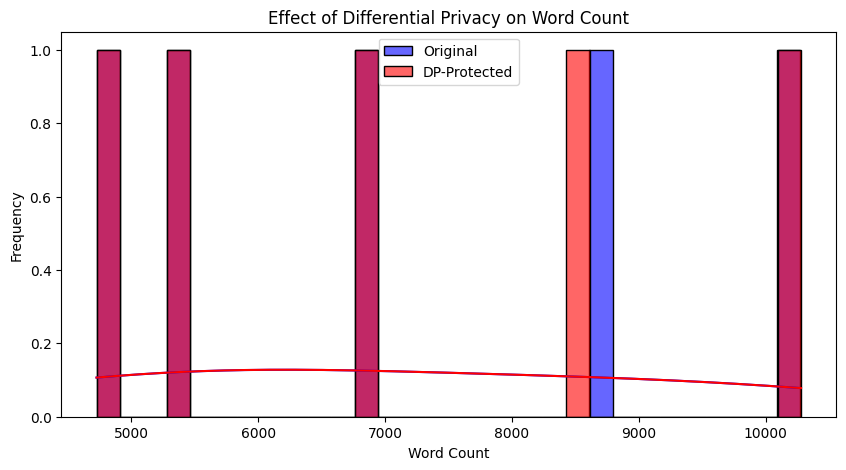

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df["Word Count"], bins=30, kde=True, label="Original", color="blue", alpha=0.6)
sns.histplot(df["DP_Word Count"], bins=30, kde=True, label="DP-Protected", color="red", alpha=0.6)
plt.title("Effect of Differential Privacy on Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()


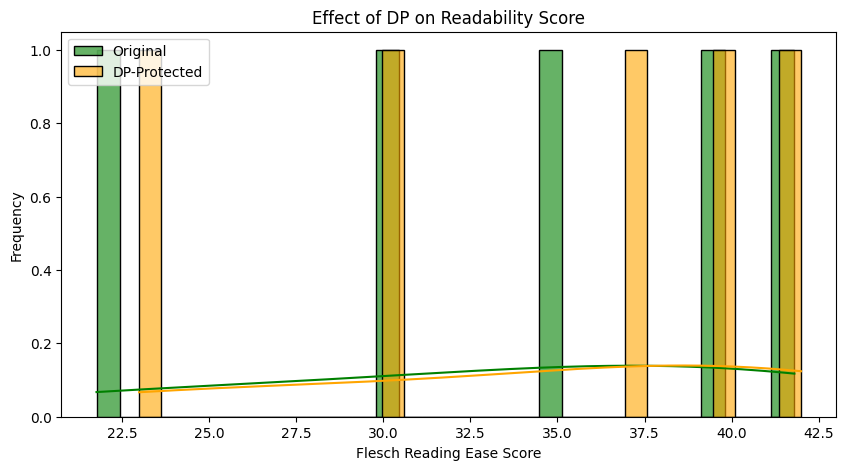

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df["Flesch Reading Ease"], bins=30, kde=True, label="Original", color="green", alpha=0.6)
sns.histplot(df["DP_Flesch Reading Ease"], bins=30, kde=True, label="DP-Protected", color="orange", alpha=0.6)
plt.title("Effect of DP on Readability Score")
plt.xlabel("Flesch Reading Ease Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


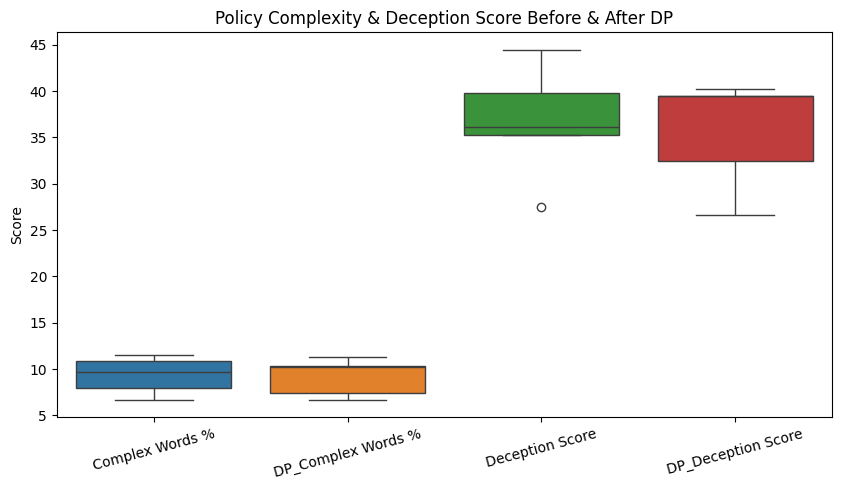

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[["Complex Words %", "DP_Complex Words %", "Deception Score", "DP_Deception Score"]])
plt.title("Policy Complexity & Deception Score Before & After DP")
plt.xticks(rotation=15)
plt.ylabel("Score")
plt.show()


In [ ]:
from wordcloud import WordCloud

# Generate Word Cloud (Using a Sample Policy Text Column)
if "Policy Text" in df.columns:
    policy_text = " ".join(df["Policy Text"].dropna())  # Combine all policies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(policy_text)

    # Display Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Privacy Policy Word Cloud")
    plt.show()
else:
    print("No 'Policy Text' column found in the dataset.")


No 'Policy Text' column found in the dataset.


In [ ]:
!pip install pandas numpy matplotlib seaborn textstat wordcloud selenium beautifulsoup4


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import textstat
from collections import Counter
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# List of companies and their current privacy policy URLs
privacy_policies = {
    "Google": "https://policies.google.com/privacy",
    "Twitter": "https://twitter.com/en/privacy",
    "Microsoft": "https://privacy.microsoft.com/en-us/privacystatement",
    "LinkedIn": "https://www.linkedin.com/legal/privacy-policy",
    "Netflix": "https://help.netflix.com/legal/privacy"
}


In [ ]:
def fetch_policy_text(url):
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    service = Service("/usr/local/bin/chromedriver")
    driver = webdriver.Chrome(service=service, options=options)

    try:
        driver.get(url)
        time.sleep(5)  # Allow JavaScript to load

        # Scroll to the bottom to load full content
        last_height = driver.execute_script("return document.body.scrollHeight")
        while True:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height

        text = driver.find_element("tag name", "body").text
        return text
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return ""
    finally:
        driver.quit()


In [ ]:
def analyze_text(text):
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    keyword_counts = Counter({kw: text.lower().count(kw) for kw in keywords})

    # Count number of sections (headers)
    section_count = text.lower().count("data collection") + text.lower().count("user rights")

    return {
        "word_count": len(words),
        "avg_sentence_length": sum(len(s.split()) for s in sentences if s) / max(len(sentences), 1),
        "section_count": section_count,
        "keyword_frequency": keyword_counts
    }


In [ ]:
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }


In [ ]:
def calculate_deception_score(text):
    readability = readability_analysis(text)
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)

    deception_score = (
        (100 - readability["Flesch Reading Ease"]) +
        readability["Gunning Fog Index"] +
        readability["Complex Words %"] +
        vague_word_count
    ) / 4  # Normalize the score

    return deception_score


In [ ]:
def apply_dp_laplace(value, epsilon=1.0, sensitivity=1):
    if pd.isnull(value):
        return value
    noise = np.random.laplace(0, sensitivity / epsilon)
    return value + noise

In [ ]:
data = []

for company, url in privacy_policies.items():
    print(f"Processing {company}...")
    text_current = fetch_policy_text(url)

    if not text_current:
        print(f"Could not fetch privacy policy for {company}")
        continue

    analysis_current = analyze_text(text_current)
    readability_current = readability_analysis(text_current)
    deception_score = calculate_deception_score(text_current)

    data.append({
        "Company": company,
        "URL": url,
        "Privacy Policy": text_current[:500],  # Store first 500 chars to avoid huge data
        "Word Count": apply_dp_laplace(analysis_current["word_count"]),
        "Avg Sentence Length": apply_dp_laplace(analysis_current["avg_sentence_length"]),
        "Section Count": apply_dp_laplace(analysis_current["section_count"]),
        "Keyword Frequency": analysis_current["keyword_frequency"],
        "Flesch Reading Ease": apply_dp_laplace(readability_current["Flesch Reading Ease"]),
        "Gunning Fog Index": apply_dp_laplace(readability_current["Gunning Fog Index"]),
        "SMOG Index": apply_dp_laplace(readability_current["SMOG Index"]),
        "Complex Words %": apply_dp_laplace(readability_current["Complex Words %"]),
        "Deception Score": apply_dp_laplace(deception_score),
        "Source": "Current Website"
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Save results
df.to_csv("privacy_policy_analysis_with_dp.csv", index=False)

# Display DataFrame
from IPython.display import display
display(df)


Processing Google...
Processing Twitter...
Processing Microsoft...
Processing LinkedIn...
Processing Netflix...


,Company,URL,Privacy Policy,Word Count,Avg Sentence Length,Section Count,Keyword Frequency,Flesch Reading Ease,Gunning Fog Index,SMOG Index,Complex Words %,Deception Score,Source
0,Google,https://policies.google.com/privacy,Privacy Policy\nSign in\nWhen you use our serv...,10270.751306,27.623898,0.393207,"{'data': 82, 'user': 38, 'third party': 2, 'co...",35.348607,12.162818,14.271830,7.361737,38.540295,Current Website
1,Twitter,https://twitter.com/en/privacy,Privacy Policy\nPrivacy Settings\nPrivacy Cent...,5441.451570,19.529603,-0.074133,"{'data': 36, 'user': 16, 'third party': 1, 'co...",38.228355,14.240475,12.867506,10.962009,35.835843,Current Website
2,Microsoft,https://privacy.microsoft.com/en-us/privacysta...,Microsoft\nPrivacy\nMicrosoft Privacy Statemen...,4728.492748,22.239839,10.351065,"{'data': 117, 'user': 21, 'third party': 6, 'c...",30.212241,13.959871,15.180045,11.426953,27.117292,Current Website
3,LinkedIn,https://www.linkedin.com/legal/privacy-policy,LinkedIn respects your privacy\nLinkedIn and 3...,6931.198993,16.268825,-0.851518,"{'data': 137, 'user': 13, 'third party': 0, 'c...",42.875748,10.379894,13.890289,10.535936,34.328064,Current Website
4,Netflix,https://help.netflix.com/legal/privacy,Help Center\nJoin Netflix\nSign In\nBack to He...,8612.424790,27.768006,4.283569,"{'data': 22, 'user': 27, 'third party': 20, 'c...",19.084489,13.154129,18.532387,8.221548,42.774280,Current Website


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import textstat
from collections import Counter
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Toggle for DP (Set to True to apply DP, False to run without DP)
USE_DIFFERENTIAL_PRIVACY = True

# List of companies and their current privacy policy URLs
privacy_policies = {
    "Google": "https://policies.google.com/privacy",
    "Twitter": "https://twitter.com/en/privacy",
    "Microsoft": "https://privacy.microsoft.com/en-us/privacystatement",
    "LinkedIn": "https://www.linkedin.com/legal/privacy-policy",
    "Netflix": "https://help.netflix.com/legal/privacy"
}

# Function to fetch privacy policy text using Selenium
def fetch_policy_text(url):
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    service = Service("/usr/local/bin/chromedriver")
    driver = webdriver.Chrome(service=service, options=options)

    try:
        driver.get(url)
        time.sleep(5)  # Allow JavaScript to load

        # Scroll to the bottom to load full content
        last_height = driver.execute_script("return document.body.scrollHeight")
        while True:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height

        text = driver.find_element("tag name", "body").text
        return text
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return ""
    finally:
        driver.quit()

# Function to analyze text content
def analyze_text(text):
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    keyword_counts = Counter({kw: text.lower().count(kw) for kw in keywords})

    # Count number of sections (headers)
    section_count = text.lower().count("data collection") + text.lower().count("user rights")

    return {
        "word_count": len(words),
        "avg_sentence_length": sum(len(s.split()) for s in sentences if s) / max(len(sentences), 1),
        "section_count": section_count,
        "keyword_frequency": keyword_counts
    }

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to calculate deception score
def calculate_deception_score(text):
    readability = readability_analysis(text)
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)

    deception_score = (
        (100 - readability["Flesch Reading Ease"]) +
        readability["Gunning Fog Index"] +
        readability["Complex Words %"] +
        vague_word_count
    ) / 4  # Normalize the score

    return deception_score

# Function to apply Differential Privacy (Laplace Mechanism)
def apply_dp_laplace(value, epsilon=1.0, sensitivity=1):
    if pd.isnull(value):
        return value
    noise = np.random.laplace(0, sensitivity / epsilon)
    return value + noise

# Function to apply DP conditionally
def apply_dp(value):
    return apply_dp_laplace(value) if USE_DIFFERENTIAL_PRIVACY else value

# Data Collection
data = []

for company, url in privacy_policies.items():
    print(f"Processing {company}...")
    text_current = fetch_policy_text(url)

    if not text_current:
        print(f"Could not fetch privacy policy for {company}")
        continue

    analysis_current = analyze_text(text_current)
    readability_current = readability_analysis(text_current)
    deception_score = calculate_deception_score(text_current)

    data.append({
        "Company": company,
        "URL": url,
        "Privacy Policy": text_current[:500],  # Store first 500 chars to avoid huge data
        "Word Count": apply_dp(analysis_current["word_count"]),
        "Avg Sentence Length": apply_dp(analysis_current["avg_sentence_length"]),
        "Section Count": apply_dp(analysis_current["section_count"]),
        "Keyword Frequency": analysis_current["keyword_frequency"],
        "Flesch Reading Ease": apply_dp(readability_current["Flesch Reading Ease"]),
        "Gunning Fog Index": apply_dp(readability_current["Gunning Fog Index"]),
        "SMOG Index": apply_dp(readability_current["SMOG Index"]),
        "Complex Words %": apply_dp(readability_current["Complex Words %"]),
        "Deception Score": apply_dp(deception_score),
        "Source": "Current Website"
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Save results
if USE_DIFFERENTIAL_PRIVACY:
    df.to_csv("privacy_policy_analysis_with_dp.csv", index=False)
else:
    df.to_csv("privacy_policy_analysis_without_dp.csv", index=False)

# Display DataFrame
from IPython.display import display
display(df)


Processing Google...
Processing Twitter...
Processing Microsoft...
Processing LinkedIn...
Processing Netflix...


,Company,URL,Privacy Policy,Word Count,Avg Sentence Length,Section Count,Keyword Frequency,Flesch Reading Ease,Gunning Fog Index,SMOG Index,Complex Words %,Deception Score,Source
0,Google,https://policies.google.com/privacy,Privacy Policy\nSign in\nWhen you use our serv...,10273.494405,27.304352,-0.393619,"{'data': 82, 'user': 38, 'third party': 2, 'co...",36.886770,13.687741,16.555922,5.805182,39.882105,Current Website
1,Twitter,https://twitter.com/en/privacy,Privacy Policy\nDownload PDF\nX Privacy Policy...,5437.695260,13.171074,0.085113,"{'data': 36, 'user': 16, 'third party': 1, 'co...",41.588182,12.166565,15.290648,11.687745,35.291187,Current Website
2,Microsoft,https://privacy.microsoft.com/en-us/privacysta...,Microsoft\nPrivacy\nMicrosoft Privacy Statemen...,4726.301550,23.794267,8.864714,"{'data': 117, 'user': 21, 'third party': 6, 'c...",30.054643,12.095393,15.117424,11.076566,27.636760,Current Website
3,LinkedIn,https://www.linkedin.com/legal/privacy-policy,LinkedIn respects your privacy\nLinkedIn and 3...,6934.028549,17.610336,0.081775,"{'data': 137, 'user': 13, 'third party': 0, 'c...",42.819223,8.653612,16.360487,9.979093,35.856152,Current Website
4,Netflix,https://help.netflix.com/legal/privacy,Help Center\nJoin Netflix\nSign In\nBack to He...,8611.737649,30.299489,0.253180,"{'data': 22, 'user': 27, 'third party': 20, 'c...",22.550073,15.067892,19.790875,7.472376,46.506796,Current Website


In [ ]:
import re
import textstat
import numpy as np

# Toggle for DP (Set to True to apply DP, False to run without DP)
USE_DIFFERENTIAL_PRIVACY = True

# Load Privacy Policy Text
with open("privacy_policy.txt", "r", encoding="utf-8") as file:
    policy_text = file.read()

# Function to count words
def count_words(text):
    words = re.findall(r'\b\w+\b', text)
    return len(words)

# Function to analyze readability
def readability_score(text):
    return textstat.flesch_reading_ease(text)

# Function to calculate deception score (simplified)
def deception_score(text):
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)
    return vague_word_count + (100 - readability_score(text))

# Function to apply Differential Privacy using Laplace noise
def apply_dp(value, epsilon=1.0):
    if USE_DIFFERENTIAL_PRIVACY:
        noise = np.random.laplace(0, 1 / epsilon)  # Adding Laplace noise
        return value + noise
    return value  # If DP is off, return the original value

# Analyzing Privacy Policy
word_count = count_words(policy_text)
readability = readability_score(policy_text)
deception = deception_score(policy_text)

# Apply DP if enabled
dp_word_count = apply_dp(word_count)
dp_readability = apply_dp(readability)
dp_deception = apply_dp(deception)

# Print Results
print("\n🔹 **Privacy Policy Analysis Without DP:**")
print(f"  - Word Count: {word_count}")
print(f"  - Readability Score: {readability:.2f}")
print(f"  - Deception Score: {deception:.2f}")

print("\n🔹 **Privacy Policy Analysis With DP (Differential Privacy Applied):**")
print(f"  - Word Count (Noisy): {dp_word_count:.2f}")
print(f"  - Readability Score (Noisy): {dp_readability:.2f}")
print(f"  - Deception Score (Noisy): {dp_deception:.2f}")


FileNotFoundError: [Errno 2] No such file or directory: 'privacy_policy.txt'

In [ ]:
import requests
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
import pandas as pd
import os

# List of companies and their privacy policy URLs
privacy_policies = {
    "Google": "https://policies.google.com/privacy",
    "Twitter": "https://twitter.com/en/privacy",
    "Microsoft": "https://privacy.microsoft.com/en-us/privacystatement",
    "LinkedIn": "https://www.linkedin.com/legal/privacy-policy",
    "Netflix": "https://help.netflix.com/legal/privacy"
}

# Function to get privacy policy text using Selenium
def get_privacy_policy(url):
    options = Options()
    options.add_argument("--headless")  # Run in headless mode (no UI)

    # Create a unique user data directory to avoid session conflicts
    user_data_dir = "/tmp/selenium_user_data"
    if not os.path.exists(user_data_dir):
        os.makedirs(user_data_dir)
    options.add_argument(f"--user-data-dir={user_data_dir}")

    driver = webdriver.Chrome(options=options)

    try:
        driver.get(url)
        time.sleep(3)  # Wait for the page to load
        text = driver.find_element("tag name", "body").text  # Get text from the body
        return text
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return ""
    finally:
        driver.quit()  # Close the driver

# Collect privacy policies data
data = []

for company, url in privacy_policies.items():
    print(f"Fetching policy for {company}...")
    policy_text = get_privacy_policy(url)

    if policy_text:
        data.append({
            "Company": company,
            "URL": url,
            "Privacy Policy": policy_text  # Store the policy text
        })
    else:
        print(f"Could not fetch policy for {company}")

# Convert data to a pandas DataFrame
df = pd.DataFrame(data)

# Save to a CSV file
df.to_csv("privacy_policies.csv", index=False)

# Show the collected data
print(df)


Fetching policy for Google...


SessionNotCreatedException: Message: session not created: probably user data directory is already in use, please specify a unique value for --user-data-dir argument, or don't use --user-data-dir
Stacktrace:
#0 0x57f7b3e9c09a <unknown>
#1 0x57f7b39638b0 <unknown>
#2 0x57f7b399cea4 <unknown>
#3 0x57f7b39988ff <unknown>
#4 0x57f7b39e929f <unknown>
#5 0x57f7b39e87d6 <unknown>
#6 0x57f7b39da753 <unknown>
#7 0x57f7b39a638e <unknown>
#8 0x57f7b39a7b51 <unknown>
#9 0x57f7b3e6576b <unknown>
#10 0x57f7b3e696f2 <unknown>
#11 0x57f7b3e518fc <unknown>
#12 0x57f7b3e6a2e4 <unknown>
#13 0x57f7b3e359cf <unknown>
#14 0x57f7b3e8acd8 <unknown>
#15 0x57f7b3e8aeb6 <unknown>
#16 0x57f7b3e9af16 <unknown>
#17 0x7b9aa7558ac3 <unknown>


In [6]:
import re
import numpy as np
import pandas as pd
from collections import Counter
from google.colab import files  # Use for manual file upload

# Function to upload a file
def upload_file():
    uploaded = files.upload()  # Upload a file manually
    file_name = list(uploaded.keys())[0]
    return file_name

# Function to count words in text
def count_words(text):
    words = re.findall(r'\b\w+\b', str(text))
    return len(words)

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Score (Higher is Easier)": textstat.flesch_reading_ease(text),
        "Fog Index (Higher is Harder)": textstat.gunning_fog(text),
        "SMOG Score (Higher is Harder)": textstat.smog_index(text),
        "Percentage of Difficult Words": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to count sections (e.g., 'Data Collection', 'User Rights')
def count_sections(text):
    section_keywords = ["data collection", "user rights", "information sharing", "privacy settings"]
    return sum(text.lower().count(sec) for sec in section_keywords)

# Function to count keyword frequency
def keyword_frequency(text):
    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    return {kw: text.lower().count(kw) for kw in keywords}

# Function to calculate deception score
def deception_score(text):
    readability = readability_analysis(text)
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)

    deception_score = (
        (100 - readability["Flesch Score (Higher is Easier)"]) +
        readability["Fog Index (Higher is Harder)"] +
        readability["Percentage of Difficult Words"] +
        vague_word_count
    ) / 4  # Normalize the score

    return deception_score

# Upload file manually
print("📂 **Upload a privacy policy file (TXT or CSV)**")
file_name = upload_file()

# Determine file type and read content
if file_name.endswith(".txt"):
    with open(file_name, "r", encoding="utf-8") as file:
        policy_text = file.read()
    df = pd.DataFrame({"Privacy Policy": [policy_text]})
elif file_name.endswith(".csv"):
    df = pd.read_csv(file_name)
    policy_text = " ".join(df.astype(str).values.flatten())  # Combine all text

# Analyze document
word_count = count_words(polic)
avg_sentence_length = sum(len(s.split()) for s in re.split(r'[.!?]', policy_text) if s) / max(len(re.split(r'[.!?]', policy_text)), 1)
section_count = count_sections(policy_text)
keyword_freq = keyword_frequency(policy_text)
readability = readability_analysis(policy_text)
deception = deception_score(policy_text)

# Add analysis to DataFrame
analysis = {
    "Total Words in Document": word_count,
    "Avg Words Per Sentence": avg_sentence_length,
    "Number of Policy Sections": section_count,
    "Occurrences of Key Terms": str(keyword_freq),
    **readability,
    "Overall Deception Indicator": deception,
    "Source": "Uploaded Document"
}

df_analysis = pd.DataFrame([analysis])

# Save updated file with analysis
output_file = "privacy_policy_analysis_with_metrics.csv"
df_analysis.to_csv(output_file, index=False)

# Display DataFrame
from IPython.display import display
display(df_analysis)

print("\n🚀 **File Saved:**", output_file)


📂 **Upload a privacy policy file (TXT or CSV)**


Saving privacy_policy_analysis.xlsx to privacy_policy_analysis (1).xlsx


NameError: name 'policy_text' is not defined

In [9]:
!pip install textstat

import re
import textstat
import numpy as np
import pandas as pd
from collections import Counter
from google.colab import files  # Use for manual file upload

# Function to upload a file manually
def upload_file():
    uploaded = files.upload()  # Upload file
    file_name = list(uploaded.keys())[0]
    return file_name


# Function to count words in text
def count_words(text):
    words = re.findall(r'\b\w+\b', str(text))
    return len(words)

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Score (Higher is Easier)": textstat.flesch_reading_ease(text),
        "Fog Index (Higher is Harder)": textstat.gunning_fog(text),
        "SMOG Score (Higher is Harder)": textstat.smog_index(text),
        "Percentage of Difficult Words": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to count sections (headers like "Data Collection", "User Rights")
def count_sections(text):
    section_keywords = ["data collection", "user rights", "information sharing", "privacy settings"]
    return sum(text.lower().count(sec) for sec in section_keywords)

# Function to count keyword frequency
def keyword_frequency(text):
    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    return {kw: text.lower().count(kw) for kw in keywords}

# Function to calculate deception score
def deception_score(text):
    readability = readability_analysis(text)
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)

    deception_score = (
        (100 - readability["Flesch Score (Higher is Easier)"]) +
        readability["Fog Index (Higher is Harder)"] +
        readability["Percentage of Difficult Words"] +
        vague_word_count
    ) / 4  # Normalize the score

    return deception_score

# Analyze each row
analysis_results = []
for index, row in df.iterrows():
    policy_text = str(row["Privacy Policy"])  # Extract text

    # Compute metrics
    word_count = count_words(policy_text)
    avg_sentence_length = sum(len(s.split()) for s in re.split(r'[.!?]', policy_text) if s) / max(len(re.split(r'[.!?]', policy_text)), 1)
    section_count = count_sections(policy_text)
    keyword_freq = keyword_frequency(policy_text)
    readability = readability_analysis(policy_text)
    deception = deception_score(policy_text)

    # Store results
    analysis_results.append({
        "Company": row["Company"],
        "URL": row["URL"],
        "Total Words in Document": word_count,
        "Avg Words Per Sentence": avg_sentence_length,
        "Number of Policy Sections": section_count,
        "Occurrences of Key Terms": str(keyword_freq),
        **readability,
        "Overall Deception Indicator": deception,
        "Source": "Uploaded File"
    })

# Convert results to DataFrame
df_analysis = pd.DataFrame(analysis_results)

# Save the updated file
output_file = "privacy_policy_analysis_with_metrics.xlsx"
df_analysis.to_excel(output_file, index=False)

# Display DataFrame
from IPython.display import display
display(df_analysis)

print("\n🚀 **File Saved:**", output_file)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.8 MB/s eta 0:00:00


,Company,URL,Total Words in Document,Avg Words Per Sentence,Number of Policy Sections,Occurrences of Key Terms,Flesch Score (Higher is Easier),Fog Index (Higher is Harder),SMOG Score (Higher is Harder),Percentage of Difficult Words,Overall Deception Indicator,Source
0,Google,https://policies.google.com/privacy,4830,29.048780,7,"{'data': 33, 'user': 8, 'third party': 1, 'con...",33.68,13.79,16.5,10.600336,31.177584,Uploaded File
1,Twitter,https://twitter.com/en/privacy,5434,19.153025,1,"{'data': 36, 'user': 16, 'third party': 1, 'co...",39.77,11.73,15.2,10.919970,35.219993,Uploaded File
2,Microsoft,https://privacy.microsoft.com/en-us/privacysta...,4726,22.504808,11,"{'data': 117, 'user': 21, 'third party': 6, 'c...",29.79,12.33,16.5,11.545064,27.521266,Uploaded File
3,LinkedIn,https://www.linkedin.com/legal/privacy-policy,6828,16.631707,0,"{'data': 137, 'user': 13, 'third party': 0, 'c...",41.70,10.49,14.4,9.796590,36.146647,Uploaded File
4,Netflix,https://help.netflix.com/legal/privacy,7806,28.025455,0,"{'data': 15, 'user': 25, 'third party': 20, 'c...",22.18,14.57,18.4,8.101761,43.622940,Uploaded File



🚀 **File Saved:** privacy_policy_analysis_with_metrics.xlsx


In [10]:
!rm /usr/local/bin/chromedriver
!wget https://storage.googleapis.com/chrome-for-testing-public/133.0.6943.53/linux64/chromedriver-linux64.zip
!unzip -o chromedriver-linux64.zip
!chmod +x chromedriver-linux64/chromedriver
!mv chromedriver-linux64/chromedriver /usr/local/bin/chromedriver

!google-chrome --version
!chromedriver --version

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import datetime
from collections import Counter
import textstat
from difflib import Differ
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time

# List of companies and their current privacy policy URLs
privacy_policies = {
    "Google": "https://policies.google.com/privacy",
    "Twitter": "https://twitter.com/en/privacy",
    "Microsoft": "https://privacy.microsoft.com/en-us/privacystatement",
    "LinkedIn": "https://www.linkedin.com/legal/privacy-policy",
    "Netflix": "https://help.netflix.com/legal/privacy"
}

# Function to fetch privacy policy text with Selenium to handle dynamic content
def fetch_policy_text(url):
    options = Options()
    options.add_argument("--headless")  # Run Chrome in headless mode
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-popup-blocking")  # Prevent pop-ups
    options.add_argument("--disable-blink-features=AutomationControlled")  # Hide Selenium usage
    options.add_argument("--disable-features=PreloadMediaEngagementData, MediaEngagementBypassAutoplayPolicies")
    options.add_argument("--disable-infobars")  # Remove automation detection
    options.add_argument("--disable-extensions")  # Disable Chrome extensions
    options.add_argument("--remote-debugging-port=9222")  # Open debugging port
    options.binary_location = "/usr/bin/google-chrome-stable"

    service = Service("/usr/local/bin/chromedriver")
    driver = webdriver.Chrome(service=service, options=options)

    try:
        # Hide Selenium automation detection
        driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", {
            "source": "Object.defineProperty(navigator, 'webdriver', {get: () => undefined})"
        })

        driver.get(url)
        time.sleep(5)  # Allow JavaScript to load

        # Scroll to the bottom to load full content
        last_height = driver.execute_script("return document.body.scrollHeight")
        while True:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height

        text = driver.find_element("tag name", "body").text
        return text
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return ""
    finally:
        driver.quit()

# Function to analyze text
def analyze_text(text):
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    keyword_counts = Counter({kw: text.lower().count(kw) for kw in keywords})
    return {
        "word_count": len(words),
        "avg_sentence_length": sum(len(s.split()) for s in sentences if s) / max(len(sentences), 1),
        "keyword_frequency": keyword_counts
    }

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to calculate deception score
def calculate_deception_score(text):
    readability = readability_analysis(text)
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)
    deception_score = (
        (100 - readability["Flesch Reading Ease"]) +
        readability["Gunning Fog Index"] +
        readability["Complex Words %"] +
        vague_word_count
    ) / 4  # Normalize the score
    return deception_score

# Function to compare changes in deception score
def compare_deception_scores(original_text, modified_text):
    original_score = calculate_deception_score(original_text)
    modified_score = calculate_deception_score(modified_text)
    score_difference = modified_score - original_score
    return {
        "Original Score": original_score,
        "Modified Score": modified_score,
        "Difference": score_difference
    }

# Collect data
data = []

for company, url in privacy_policies.items():
    print(f"Processing {company}...")
    text_current = fetch_policy_text(url)
    if not text_current:
        print(f"Could not fetch privacy policy for {company}")
    analysis_current = analyze_text(text_current)
    readability_current = readability_analysis(text_current)
    deception_score = calculate_deception_score(text_current)

    data.append({
        "Company": company,
        "URL": url,
        "Privacy Policy": text_current,  # Store full text
        "Word Count": analysis_current["word_count"],
        "Avg Sentence Length": analysis_current["avg_sentence_length"],
        "Keyword Frequency": analysis_current["keyword_frequency"],
        "Flesch Reading Ease": readability_current["Flesch Reading Ease"],
        "Gunning Fog Index": readability_current["Gunning Fog Index"],
        "SMOG Index": readability_current["SMOG Index"],
        "Complex Words %": readability_current["Complex Words %"],
        "Deception Score": deception_score,
        "Source": "Current Website"
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Save results
df.to_csv("privacy_policy_analysis.csv", index=False)

# Display DataFrame
from IPython.display import display
display(df)


--2025-02-12 01:59:53--  https://storage.googleapis.com/chrome-for-testing-public/133.0.6943.53/linux64/chromedriver-linux64.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.207, 108.177.97.207, 108.177.125.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9456679 (9.0M) [application/zip]
Saving to: ‘chromedriver-linux64.zip.3’

chromedriver-linux6 100%[===================>]   9.02M  6.29MB/s    in 1.4s    

2025-02-12 01:59:54 (6.29 MB/s) - ‘chromedriver-linux64.zip.3’ saved [9456679/9456679]

Archive:  chromedriver-linux64.zip
  inflating: chromedriver-linux64/LICENSE.chromedriver  
  inflating: chromedriver-linux64/THIRD_PARTY_NOTICES.chromedriver  
  inflating: chromedriver-linux64/chromedriver  
Google Chrome 133.0.6943.53 
ChromeDriver 133.0.6943.53 (9a80935019b0925b01cc21d254da203bc3986f04-refs/branch-heads/6943@{#1389})
Processing Google...
Pr

,Company,URL,Privacy Policy,Word Count,Avg Sentence Length,Keyword Frequency,Flesch Reading Ease,Gunning Fog Index,SMOG Index,Complex Words %,Deception Score,Source
0,Google,https://policies.google.com/privacy,Privacy Policy\nSign in\nWhen you use our serv...,4830,29.048780,"{'data': 33, 'user': 8, 'third party': 1, 'con...",33.68,13.79,16.5,10.600336,31.177584,Current Website
1,Twitter,https://twitter.com/en/privacy,Privacy Policy\nDownload PDF\nX Privacy Policy...,5434,19.153025,"{'data': 36, 'user': 16, 'third party': 1, 'co...",39.77,11.73,15.2,10.919970,35.219993,Current Website
2,Microsoft,https://privacy.microsoft.com/en-us/privacysta...,Microsoft\nPrivacy\nMicrosoft Privacy Statemen...,4726,22.504808,"{'data': 117, 'user': 21, 'third party': 6, 'c...",29.79,12.33,16.5,11.545064,27.521266,Current Website
3,LinkedIn,https://www.linkedin.com/legal/privacy-policy,Open navigation\nPrivacy Policy\nEffective Sep...,6828,16.631707,"{'data': 137, 'user': 13, 'third party': 0, 'c...",41.70,10.49,14.4,9.796590,36.146647,Current Website
4,Netflix,https://help.netflix.com/legal/privacy,Help Center\nJoin Netflix\nSign In\nWait times...,7806,28.025455,"{'data': 15, 'user': 25, 'third party': 20, 'c...",22.18,14.57,18.4,8.101761,43.622940,Current Website


In [3]:
# Install Google Chrome (Debian-based systems like Ubuntu)
!wget -q -O google-chrome.deb https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!sudo dpkg -i google-chrome.deb || sudo apt-get -f install -y

# Install Selenium
!pip install selenium

!rm /usr/local/bin/chromedriver
!wget https://storage.googleapis.com/chrome-for-testing-public/133.0.6943.53/linux64/chromedriver-linux64.zip
!unzip -o chromedriver-linux64.zip
!chmod +x chromedriver-linux64/chromedriver
!mv chromedriver-linux64/chromedriver /usr/local/bin/chromedriver

!google-chrome --version
!chromedriver --version

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import datetime
from collections import Counter
from difflib import Differ
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time

# List of companies and their current privacy policy URLs
privacy_policies = {
    "Google": "https://policies.google.com/privacy",
}

# Function to fetch privacy policy text with Selenium to handle dynamic content
def fetch_policy_text(url):
    options = Options()
    options.add_argument("--headless")  # Run Chrome in headless mode
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-popup-blocking")  # Prevent pop-ups
    options.add_argument("--disable-blink-features=AutomationControlled")  # Hide Selenium usage
    options.add_argument("--disable-features=PreloadMediaEngagementData, MediaEngagementBypassAutoplayPolicies")
    options.add_argument("--disable-infobars")  # Remove automation detection
    options.add_argument("--disable-extensions")  # Disable Chrome extensions
    options.add_argument("--remote-debugging-port=9222")  # Open debugging port
    options.binary_location = "/usr/bin/google-chrome-stable"

    service = Service("/usr/local/bin/chromedriver")
    driver = webdriver.Chrome(service=service, options=options)

    try:
        # Hide Selenium automation detection
        driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", {
            "source": "Object.defineProperty(navigator, 'webdriver', {get: () => undefined})"
        })

        driver.get(url)
        time.sleep(5)  # Allow JavaScript to load

        # Scroll to the bottom to load full content
        last_height = driver.execute_script("return document.body.scrollHeight")
        while True:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height

        text = driver.find_element("tag name", "body").text
        return text
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return ""
    finally:
        driver.quit()


# Collect data
data = []

for company, url in privacy_policies.items():
    print(f"Processing {company}...")
    text_current = fetch_policy_text(url)
    if not text_current:
        print(f"Could not fetch privacy policy for {company}")

    data.append({
        "Company": company,
        "URL": url,
        "Privacy Policy": text_current,  # Store full text
        "Source": "Current Website"
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Save results
df.to_csv("privacy_policy_analysis.csv", index=False)

# Display DataFrame
from IPython.display import display
display(df)


Selecting previously unselected package google-chrome-stable.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack google-chrome.deb ...
Unpacking google-chrome-stable (133.0.6943.98-1) ...
dpkg: dependency problems prevent configuration of google-chrome-stable:
 google-chrome-stable depends on libvulkan1; however:
  Package libvulkan1 is not installed.

dpkg: error processing package google-chrome-stable (--install):
 dependency problems - leaving unconfigured
Processing triggers for mailcap (3.70+nmu1ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
Errors were encountered while processing:
 google-chrome-stable
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Correcting dependencies... Done
The following additional packages will be installed:
  libvulkan1 mesa-vulkan-drivers
The following NEW packages will be installed:
  libvulkan1 mesa-vulkan-drivers
0 upgraded, 2 newly installed, 0 to

,Company,URL,Privacy Policy,Source
0,Google,https://policies.google.com/privacy,Privacy Policy\nSign in\nWhen you use our serv...,Current Website


In [9]:
import pandas as pd
import re
import io
from collections import Counter
import textstat
from google.colab import files

# Upload the file
uploaded = files.upload()

# Get the file name dynamically
file_name = list(uploaded.keys())[0]

# Read the uploaded CSV file
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# Ensure "Privacy Policy" column exists
if "Privacy Policy" not in df.columns:
    raise ValueError("No 'Privacy Policy' column found in the uploaded file.")

# Function to analyze text
def analyze_text(text):
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    keyword_counts = Counter({kw: text.lower().count(kw) for kw in keywords})

    return {
        "word_count": len(words),
        "avg_sentence_length": sum(len(s.split()) for s in sentences if s) / max(len(sentences), 1),
        "keyword_frequency": keyword_counts
    }

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Process each policy
updated_data = []
for _, row in df.iterrows():
    policy_text = str(row["Privacy Policy"])

    # Get text analysis
    text_analysis = analyze_text(policy_text)
    readability_scores = readability_analysis(policy_text)

    # Merge results into a single dictionary
    result = {
        "Company": row["Company"],
        "URL": row["URL"] if "URL" in row else "",
        "Privacy Policy": policy_text,
        "Word Count": text_analysis["word_count"],
        "Avg Sentence Length": text_analysis["avg_sentence_length"],
        "Keyword Frequency": text_analysis["keyword_frequency"],
        "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
        "Gunning Fog Index": readability_scores["Gunning Fog Index"],
        "SMOG Index": readability_scores["SMOG Index"],
        "Complex Words %": readability_scores["Complex Words %"]
    }

    updated_data.append(result)

# Convert to DataFrame
updated_df = pd.DataFrame(updated_data)

# Save the updated DataFrame locally
output_file = "updated_privacy_policy_analysis.csv"
updated_df.to_csv(output_file, index=False)

# Display the updated DataFrame
from IPython.display import display
display(updated_df)

# Download the updated file
files.download(output_file)


Saving privacy_policy_analysis.csv to privacy_policy_analysis (4).csv


,Company,URL,Privacy Policy,Word Count,Avg Sentence Length,Keyword Frequency,Flesch Reading Ease,Gunning Fog Index,SMOG Index,Complex Words %
0,Google,https://policies.google.com/privacy,Privacy Policy\nSign in\nWhen you use our serv...,6219,25.665272,"{'data': 47, 'user': 11, 'third party': 3, 'co...",27.56,12.79,16.2,9.936368


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import pandas as pd
import re
import io
from collections import Counter
import textstat
from google.colab import files

# Upload the file
uploaded = files.upload()

# Get the file name dynamically
file_name = list(uploaded.keys())[0]

# Read the uploaded CSV file
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# Ensure "Privacy Policy" column exists
if "Privacy Policy" not in df.columns:
    raise ValueError("No 'Privacy Policy' column found in the uploaded file.")

# Function to analyze text
def analyze_text(text):
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    keyword_counts = Counter({kw: text.lower().count(kw) for kw in keywords})

    return {
        "word_count": len(words),
        "avg_sentence_length": sum(len(s.split()) for s in sentences if s) / max(len(sentences), 1),
        "keyword_frequency": keyword_counts
    }

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to calculate deception score
def calculate_deception_score(text):
    readability = readability_analysis(text)
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)

    # Deception score calculation
    deception_score = (
        (100 - readability["Flesch Reading Ease"]) +
        readability["Gunning Fog Index"] +
        readability["Complex Words %"] +
        vague_word_count
    ) / 4  # Normalize the score

    return deception_score

# Process each policy
updated_data = []
for _, row in df.iterrows():
    policy_text = str(row["Privacy Policy"])

    # Get text analysis
    text_analysis = analyze_text(policy_text)
    readability_scores = readability_analysis(policy_text)
    deception_score = calculate_deception_score(policy_text)

    # Merge results into a single dictionary
    result = {
        "Company": row["Company"],
        "URL": row["URL"] if "URL" in row else "",
        "Privacy Policy": policy_text,
        "Word Count": text_analysis["word_count"],
        "Avg Sentence Length": text_analysis["avg_sentence_length"],
        "Keyword Frequency": text_analysis["keyword_frequency"],
        "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
        "Gunning Fog Index": readability_scores["Gunning Fog Index"],
        "SMOG Index": readability_scores["SMOG Index"],
        "Complex Words %": readability_scores["Complex Words %"],
        "Deception Score": deception_score  # New deception score added
    }

    updated_data.append(result)

# Convert to DataFrame
updated_df = pd.DataFrame(updated_data)

# Save the updated DataFrame locally
output_file = "updated_privacy_policy_analysis.csv"
updated_df.to_csv(output_file, index=False)

# Display the updated DataFrame
from IPython.display import display
display(updated_df)

# Download the updated file
files.download(output_file)


Saving privacy_policy_analysis.csv to privacy_policy_analysis (5).csv


,Company,URL,Privacy Policy,Word Count,Avg Sentence Length,Keyword Frequency,Flesch Reading Ease,Gunning Fog Index,SMOG Index,Complex Words %,Deception Score
0,Google,https://policies.google.com/privacy,Privacy Policy\nSign in\nWhen you use our serv...,6219,25.665272,"{'data': 47, 'user': 11, 'third party': 3, 'co...",27.56,12.79,16.2,9.936368,34.791592


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
!pip install textstat nltk textblob
import pandas as pd
import re
import io
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
from collections import Counter
import textstat
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from textblob import TextBlob
from google.colab import files

# Suppress warnings
warnings.filterwarnings("ignore")

# Ensure necessary NLTK resources are available
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Upload the file
uploaded = files.upload()

# Get the file name dynamically
file_name = list(uploaded.keys())[0]

# Read the uploaded CSV file
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# Ensure "Privacy Policy" column exists
if "Privacy Policy" not in df.columns:
    raise ValueError("No 'Privacy Policy' column found in the uploaded file.")

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to analyze deception markers
def content_analysis(sentence):
    """Extract deception markers from a sentence."""
    words = word_tokenize(sentence)
    text_blob = TextBlob(sentence)

    ambiguity_words = ["may", "might", "could", "some", "often", "possibly", "typically", "generally"]
    passive_voice_words = ["is", "was", "were", "been", "being"]
    legal_jargon = ["to the extent", "where applicable", "as necessary", "permissible by law"]

    ambiguity_score = sum(1 for word in words if word.lower() in ambiguity_words)
    passive_voice_score = sum(1 for word in words if word.lower() in passive_voice_words)
    legal_complexity_score = sum(1 for word in words if word.lower() in legal_jargon)
    readability_score = text_blob.sentiment.polarity  # Approximate readability

    return {
        "Ambiguity Score": ambiguity_score,
        "Passive Voice Score": passive_voice_score,
        "Legal Complexity Score": legal_complexity_score,
        "Readability Score": readability_score
    }

# Function to compute deception score
def compute_deception_score(content_features):
    """Compute deception score based on content analysis."""
    weights = {
        "Ambiguity Score": 0.3,
        "Passive Voice Score": 0.2,
        "Legal Complexity Score": 0.3,
        "Readability Score": 0.2
    }
    deception_score = sum(content_features[feature] * weights[feature] for feature in weights)
    return deception_score

# Function to apply differential privacy to deception score
def dp_add_noise(value, epsilon=1.0):
    """Applies Laplace noise for differential privacy."""
    sensitivity = 1.0
    noise = np.random.laplace(0, sensitivity / epsilon)
    return value + noise

# Function to modify sentences using differential privacy
def dp_modify_sentence(sentence, epsilon=0.5):
    """Apply differential privacy-based text modification."""
    words = word_tokenize(sentence)
    perturbed_sentence = []

    for word in words:
        if random.random() < epsilon:
            synonyms = wordnet.synsets(word)
            if synonyms:
                synonym_words = [lemma.name().replace('_', ' ') for lemma in synonyms[0].lemmas()]
                if synonym_words:
                    perturbed_sentence.append(random.choice(synonym_words))
                else:
                    perturbed_sentence.append(word)
            else:
                perturbed_sentence.append(word)
        else:
            perturbed_sentence.append(word)

    if len(perturbed_sentence) > 1:
        perturbed_sentence[0] = random.choice(["A service provider", "An organization", "A company"])
        for i in range(len(perturbed_sentence)):
            if perturbed_sentence[i] in ["collects", "stores", "uses"]:
                perturbed_sentence[i] = random.choice(["may gather", "sometimes retains", "processes"])

    return ' '.join(perturbed_sentence)

# Process each policy
updated_data = []
for _, row in df.iterrows():
    policy_text = str(row["Privacy Policy"])
    sentences = sent_tokenize(policy_text)[:100]  # Limit analysis to first 100 sentences

    for sentence in sentences:
        try:
            # Original Sentence Analysis
            original_features = content_analysis(sentence)
            original_score = compute_deception_score(original_features)

            # DP-based Modified Sentence Analysis
            modified_sentence = dp_modify_sentence(sentence)
            modified_features = content_analysis(modified_sentence)

            # Apply DP noise to deception score components
            dp_features = {key: dp_add_noise(value, epsilon=1.0) for key, value in modified_features.items()}
            modified_score = compute_deception_score(dp_features)

            # Calculate percentage change
            score_change = ((modified_score - original_score) / original_score) * 100 if original_score > 0 else 0

            updated_data.append({
                "Company": row["Company"],
                "Original Sentence": sentence,
                "Original Deception Score": round(original_score, 2),
                "Modified Sentence": modified_sentence,
                "Modified Deception Score": round(modified_score, 2),
                "Percentage Change": round(score_change, 2)
            })
        except Exception as e:
            print(f"Error processing sentence: {sentence}\nError: {e}")

# Convert results to DataFrame
updated_df = pd.DataFrame(updated_data)

# Save the updated DataFrame locally
output_file = "updated_privacy_policy_analysis.csv"
updated_df.to_csv(output_file, index=False)

# Display the updated DataFrame
from IPython.display import display
display(updated_df)

# Generate visualization
plt.figure(figsize=(12, 6))
plt.barh(updated_df['Original Sentence'][:20], updated_df['Percentage Change'][:20], color='blue')
plt.xlabel("Percentage Change in Deception Score")
plt.ylabel("Original Sentence")
plt.title("Impact of Differential Privacy on Deception Score")
plt.show()

# Download the updated file
files.download(output_file)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Saving privacy_policy_analysis.csv to privacy_policy_analysis (6).csv


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [13]:
import nltk

# Ensure all necessary NLTK resources are downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

# Ensure Punkt tokenizer is available
nltk.download('punkt_tab')  # This should fix your LookupError


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Saving privacy_policy_analysis.csv to privacy_policy_analysis (7).csv


,Company,Original Sentence,Original Deception Score,Modified Sentence,Modified Deception Score,Percentage Change
0,Google,Privacy Policy\nSign in\nWhen you use our serv...,0.00,A service provider Policy sign in When you uti...,0.31,0.00
1,Google,We understand this is a big responsibility and...,0.17,A service provider understand this be a large ...,-0.53,-413.16
2,Google,This Privacy Policy is meant to help you under...,0.20,An organization privacy policy be mean to help...,0.65,222.87
3,Google,Privacy Checkup\nLooking to change your privac...,0.00,A company Checkup Looking to change your priva...,0.43,0.00
4,Google,Take the Privacy Checkup\nEffective September ...,0.05,A company the privateness medical Effective Se...,0.23,406.07
...,...,...,...,...,...,...
95,Google,Go to How Google uses information from sites o...,0.00,A company to How Google processes information ...,-0.57,0.00
96,Google,"You can browse by date and by topic, and delet...",0.00,An organization can browse by date and by topi...,0.75,0.00
97,Google,Go to My Activity\nGoogle Dashboard\nGoogle Da...,0.00,A service provider to My Activity Google Dashb...,-0.82,0.00
98,Google,Go to Dashboard\nYour personal information\nMa...,0.00,A service provider to splashboard Your persona...,0.51,0.00


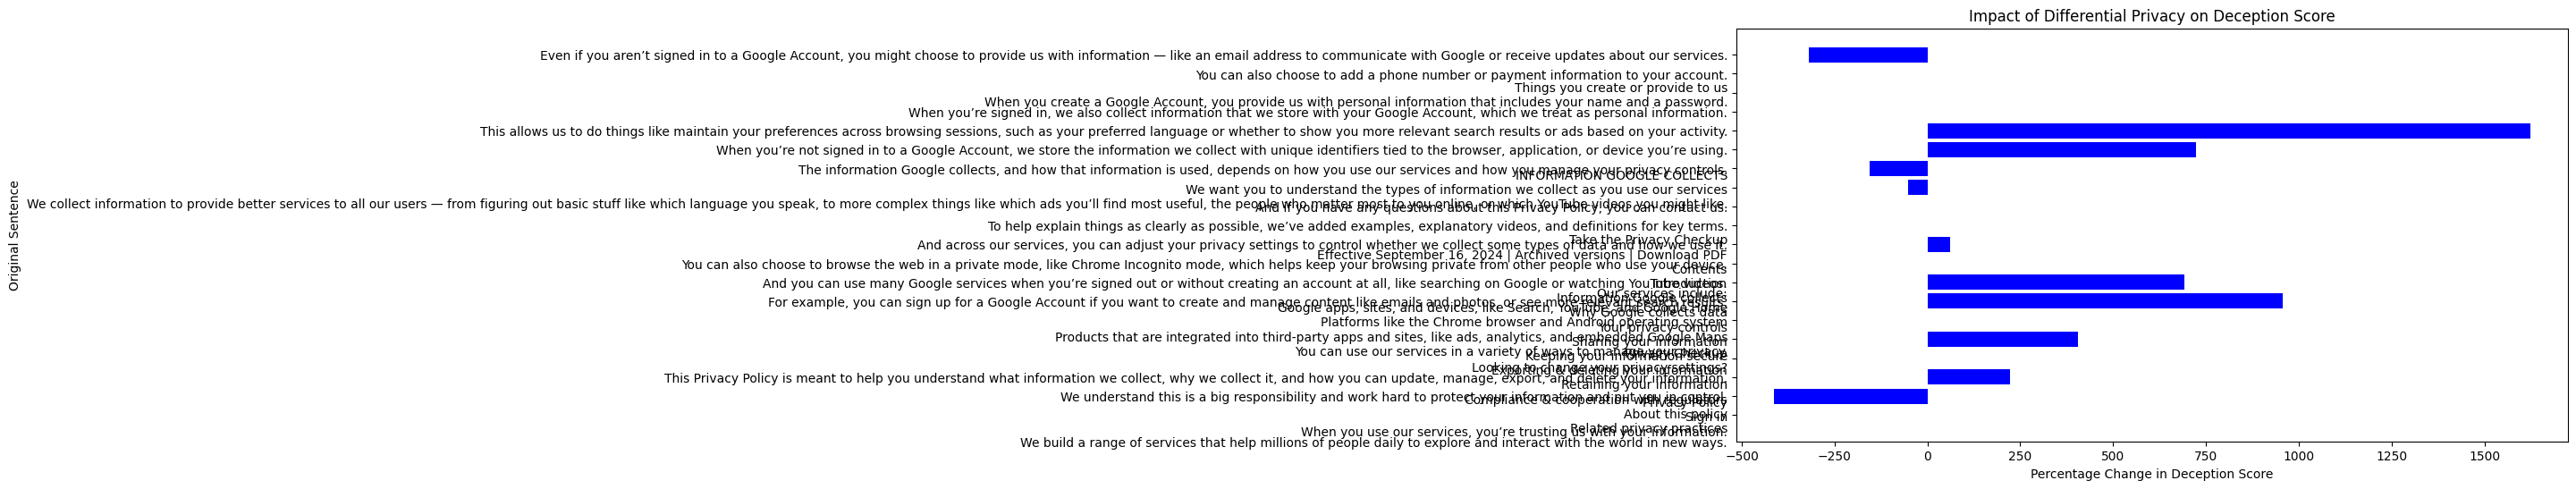

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
!pip install textstat nltk textblob
import pandas as pd
import re
import io
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
from collections import Counter
import textstat
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from textblob import TextBlob
from google.colab import files

# Suppress warnings
warnings.filterwarnings("ignore")

# Ensure necessary NLTK resources are available
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Upload the file
uploaded = files.upload()

# Get the file name dynamically
file_name = list(uploaded.keys())[0]

# Read the uploaded CSV file
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# Ensure "Privacy Policy" column exists
if "Privacy Policy" not in df.columns:
    raise ValueError("No 'Privacy Policy' column found in the uploaded file.")

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to analyze deception markers
def content_analysis(sentence):
    """Extract deception markers from a sentence."""
    words = word_tokenize(sentence)
    text_blob = TextBlob(sentence)

    ambiguity_words = ["may", "might", "could", "some", "often", "possibly", "typically", "generally"]
    passive_voice_words = ["is", "was", "were", "been", "being"]
    legal_jargon = ["to the extent", "where applicable", "as necessary", "permissible by law"]

    ambiguity_score = sum(1 for word in words if word.lower() in ambiguity_words)
    passive_voice_score = sum(1 for word in words if word.lower() in passive_voice_words)
    legal_complexity_score = sum(1 for word in words if word.lower() in legal_jargon)
    readability_score = text_blob.sentiment.polarity  # Approximate readability

    return {
        "Ambiguity Score": ambiguity_score,
        "Passive Voice Score": passive_voice_score,
        "Legal Complexity Score": legal_complexity_score,
        "Readability Score": readability_score
    }

# Function to compute deception score
def compute_deception_score(content_features):
    """Compute deception score based on content analysis."""
    weights = {
        "Ambiguity Score": 0.3,
        "Passive Voice Score": 0.2,
        "Legal Complexity Score": 0.3,
        "Readability Score": 0.2
    }
    deception_score = sum(content_features[feature] * weights[feature] for feature in weights)
    return deception_score

# Function to apply differential privacy to deception score
def dp_add_noise(value, epsilon=1.0):
    """Applies Laplace noise for differential privacy."""
    sensitivity = 1.0
    noise = np.random.laplace(0, sensitivity / epsilon)
    return value + noise

# Function to modify sentences using differential privacy
def dp_modify_sentence(sentence, epsilon=0.5):
    """Apply differential privacy-based text modification."""
    words = word_tokenize(sentence)
    perturbed_sentence = []

    for word in words:
        if random.random() < epsilon:
            synonyms = wordnet.synsets(word)
            if synonyms:
                synonym_words = [lemma.name().replace('_', ' ') for lemma in synonyms[0].lemmas()]
                if synonym_words:
                    perturbed_sentence.append(random.choice(synonym_words))
                else:
                    perturbed_sentence.append(word)
            else:
                perturbed_sentence.append(word)
        else:
            perturbed_sentence.append(word)

    if len(perturbed_sentence) > 1:
        perturbed_sentence[0] = random.choice(["A service provider", "An organization", "A company"])
        for i in range(len(perturbed_sentence)):
            if perturbed_sentence[i] in ["collects", "stores", "uses"]:
                perturbed_sentence[i] = random.choice(["may gather", "sometimes retains", "processes"])

    return ' '.join(perturbed_sentence)

# Process each policy
updated_data = []
for _, row in df.iterrows():
    policy_text = str(row["Privacy Policy"])
    sentences = sent_tokenize(policy_text)[:100]  # Limit analysis to first 100 sentences

    for sentence in sentences:
        try:
            # Original Sentence Analysis
            original_features = content_analysis(sentence)
            original_score = compute_deception_score(original_features)

            # DP-based Modified Sentence Analysis
            modified_sentence = dp_modify_sentence(sentence)
            modified_features = content_analysis(modified_sentence)

            # Apply DP noise to deception score components
            dp_features = {key: dp_add_noise(value, epsilon=1.0) for key, value in modified_features.items()}
            modified_score = compute_deception_score(dp_features)

            # Calculate percentage change
            score_change = ((modified_score - original_score) / original_score) * 100 if original_score > 0 else 0

            updated_data.append({
                "Company": row["Company"],
                "Original Sentence": sentence,
                "Original Deception Score": round(original_score, 2),
                "Modified Sentence": modified_sentence,
                "Modified Deception Score": round(modified_score, 2),
                "Percentage Change": round(score_change, 2)
            })
        except Exception as e:
            print(f"Error processing sentence: {sentence}\nError: {e}")

# Convert results to DataFrame
updated_df = pd.DataFrame(updated_data)

# Save the updated DataFrame locally
output_file = "updated_privacy_policy_analysis.csv"
updated_df.to_csv(output_file, index=False)

# Display the updated DataFrame
from IPython.display import display
display(updated_df)

# Generate visualization
plt.figure(figsize=(12, 6))
plt.barh(updated_df['Original Sentence'][:20], updated_df['Percentage Change'][:20], color='blue')
plt.xlabel("Percentage Change in Deception Score")
plt.ylabel("Original Sentence")
plt.title("Impact of Differential Privacy on Deception Score")
plt.show()

# Download the updated file
files.download(output_file)


In [16]:
import pandas as pd
import re
import io
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
from collections import Counter
import textstat
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from textblob import TextBlob
from google.colab import files
from bs4 import BeautifulSoup
import requests

# Suppress warnings
warnings.filterwarnings("ignore")

# Upload the file
uploaded = files.upload()

# Get the file name dynamically
file_name = list(uploaded.keys())[0]

# Read the uploaded CSV file
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# Ensure "Privacy Policy" column exists
if "Privacy Policy" not in df.columns:
    raise ValueError("No 'Privacy Policy' column found in the uploaded file.")

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to analyze deception markers
def content_analysis(sentence):
    words = word_tokenize(sentence)
    text_blob = TextBlob(sentence)

    ambiguity_words = ["may", "might", "could", "some", "often", "possibly", "typically", "generally"]
    passive_voice_words = ["is", "was", "were", "been", "being"]
    legal_jargon = ["to the extent", "where applicable", "as necessary", "permissible by law"]

    ambiguity_score = sum(1 for word in words if word.lower() in ambiguity_words)
    passive_voice_score = sum(1 for word in words if word.lower() in passive_voice_words)
    legal_complexity_score = sum(1 for word in words if word.lower() in legal_jargon)
    readability_score = text_blob.sentiment.polarity

    return {
        "Ambiguity Score": ambiguity_score,
        "Passive Voice Score": passive_voice_score,
        "Legal Complexity Score": legal_complexity_score,
        "Readability Score": readability_score
    }

# Function to compute deception score
def compute_deception_score(content_features):
    weights = {
        "Ambiguity Score": 0.3,
        "Passive Voice Score": 0.2,
        "Legal Complexity Score": 0.3,
        "Readability Score": 0.2
    }
    deception_score = sum(content_features[feature] * weights[feature] for feature in weights)
    return deception_score

# Function to apply Differential Privacy to deception score
def dp_add_noise(value, epsilon=1.0):
    sensitivity = 1.0
    noise = np.random.laplace(0, sensitivity / epsilon)
    return value + noise

# Function to analyze text content
def analyze_text(text):
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    keyword_counts = Counter({kw: text.lower().count(kw) for kw in keywords})

    return {
        "word_count": len(words),
        "avg_sentence_length": sum(len(s.split()) for s in sentences if s) / max(len(sentences), 1),
        "keyword_frequency": keyword_counts
    }

# Process each policy
updated_data = []
for _, row in df.iterrows():
    policy_text = str(row["Privacy Policy"])

    # Get text analysis
    text_analysis = analyze_text(policy_text)
    readability_scores = readability_analysis(policy_text)
    original_deception_score = compute_deception_score(content_analysis(policy_text))

    # Apply DP to readability scores
    dp_readability_scores = {key: dp_add_noise(value, epsilon=1.0) for key, value in readability_scores.items()}

    # Apply DP to deception score
    dp_deception_score = dp_add_noise(original_deception_score, epsilon=1.0)

    # Merge results into a single dictionary
    result = {
        "Company": row["Company"],
        "URL": row["URL"] if "URL" in row else "",
        "Privacy Policy": policy_text,

        # Original Analysis
        "Word Count": text_analysis["word_count"],
        "Avg Sentence Length": text_analysis["avg_sentence_length"],
        "Keyword Frequency": text_analysis["keyword_frequency"],
        "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
        "Gunning Fog Index": readability_scores["Gunning Fog Index"],
        "SMOG Index": readability_scores["SMOG Index"],
        "Complex Words %": readability_scores["Complex Words %"],
        "Deception Score": original_deception_score,

        # Differential Privacy-Modified Scores
        "DP Flesch Reading Ease": dp_readability_scores["Flesch Reading Ease"],
        "DP Gunning Fog Index": dp_readability_scores["Gunning Fog Index"],
        "DP SMOG Index": dp_readability_scores["SMOG Index"],
        "DP Complex Words %": dp_readability_scores["Complex Words %"],
        "DP Deception Score": dp_deception_score
    }

    updated_data.append(result)

# Convert to DataFrame
updated_df = pd.DataFrame(updated_data)

# Save the updated DataFrame to Excel
output_file = "updated_privacy_policy_analysis.xlsx"
updated_df.to_excel(output_file, index=False, engine='openpyxl')

# Display the updated DataFrame
from IPython.display import display
display(updated_df)

# Download the updated Excel file
files.download(output_file)


Saving updated_privacy_policy_analysis.csv to updated_privacy_policy_analysis (1).csv


,Company,URL,Privacy Policy,Word Count,Avg Sentence Length,Keyword Frequency,Flesch Reading Ease,Gunning Fog Index,SMOG Index,Complex Words %,Deception Score,DP Flesch Reading Ease,DP Gunning Fog Index,DP SMOG Index,DP Complex Words %,DP Deception Score
0,Google,https://policies.google.com/privacy,Privacy Policy\nSign in\nWhen you use our serv...,6219,25.665272,"{'data': 47, 'user': 11, 'third party': 3, 'co...",27.56,12.79,16.2,9.936368,21.01819,27.110423,13.097605,17.328387,11.242932,21.647189


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import pandas as pd
import re
import io
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
from collections import Counter
import textstat
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from textblob import TextBlob
from google.colab import files
from bs4 import BeautifulSoup
import requests

# Suppress warnings
warnings.filterwarnings("ignore")

# Upload the file
uploaded = files.upload()

# Get the file name dynamically
file_name = list(uploaded.keys())[0]

# Read the uploaded CSV file
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# Ensure "Privacy Policy" column exists
if "Privacy Policy" not in df.columns:
    raise ValueError("No 'Privacy Policy' column found in the uploaded file.")

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to analyze deception markers
def content_analysis(sentence):
    words = word_tokenize(sentence)
    text_blob = TextBlob(sentence)

    ambiguity_words = ["may", "might", "could", "some", "often", "possibly", "typically", "generally"]
    passive_voice_words = ["is", "was", "were", "been", "being"]
    legal_jargon = ["to the extent", "where applicable", "as necessary", "permissible by law"]

    ambiguity_score = sum(1 for word in words if word.lower() in ambiguity_words)
    passive_voice_score = sum(1 for word in words if word.lower() in passive_voice_words)
    legal_complexity_score = sum(1 for word in words if word.lower() in legal_jargon)
    readability_score = text_blob.sentiment.polarity

    return {
        "Ambiguity Score": ambiguity_score,
        "Passive Voice Score": passive_voice_score,
        "Legal Complexity Score": legal_complexity_score,
        "Readability Score": readability_score
    }

# Function to compute deception score
def compute_deception_score(content_features):
    weights = {
        "Ambiguity Score": 0.3,
        "Passive Voice Score": 0.2,
        "Legal Complexity Score": 0.3,
        "Readability Score": 0.2
    }
    deception_score = sum(content_features[feature] * weights[feature] for feature in weights)
    return deception_score

# Function to apply Differential Privacy to deception score
def dp_add_noise(value, epsilon=1.0):
    sensitivity = 1.0
    noise = np.random.laplace(0, sensitivity / epsilon)
    return value + noise

# Function to analyze text content
def analyze_text(text):
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    keyword_counts = Counter({kw: text.lower().count(kw) for kw in keywords})

    return {
        "word_count": len(words),
        "avg_sentence_length": sum(len(s.split()) for s in sentences if s) / max(len(sentences), 1),
        "keyword_frequency": keyword_counts
    }

# Process each policy
updated_data = []
for _, row in df.iterrows():
    policy_text = str(row["Privacy Policy"])

    # Get text analysis
    text_analysis = analyze_text(policy_text)
    readability_scores = readability_analysis(policy_text)
    original_deception_score = compute_deception_score(content_analysis(policy_text))

    # Apply DP to readability scores
    dp_readability_scores = {key: dp_add_noise(value, epsilon=1.0) for key, value in readability_scores.items()}

    # Apply DP to deception score
    dp_deception_score = dp_add_noise(original_deception_score, epsilon=1.0)

    # Merge results into a single dictionary
    result = {
        "Company": row["Company"],
        "URL": row["URL"] if "URL" in row else "",
        "Privacy Policy": policy_text,

        # Original Analysis
        "Word Count": text_analysis["word_count"],
        "Avg Sentence Length": text_analysis["avg_sentence_length"],
        "Keyword Frequency": text_analysis["keyword_frequency"],
        "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
        "Gunning Fog Index": readability_scores["Gunning Fog Index"],
        "SMOG Index": readability_scores["SMOG Index"],
        "Complex Words %": readability_scores["Complex Words %"],
        "Deception Score": original_deception_score,

        # Differential Privacy-Modified Scores
        "DP Flesch Reading Ease": dp_readability_scores["Flesch Reading Ease"],
        "DP Gunning Fog Index": dp_readability_scores["Gunning Fog Index"],
        "DP SMOG Index": dp_readability_scores["SMOG Index"],
        "DP Complex Words %": dp_readability_scores["Complex Words %"],
        "DP Deception Score": dp_deception_score
    }

    updated_data.append(result)

# Convert to DataFrame
updated_df = pd.DataFrame(updated_data)

# Save the updated DataFrame to Excel
output_file = "updated_privacy_policy_analysis.xlsx"
updated_df.to_excel(output_file, index=False, engine='openpyxl')

# Display the updated DataFrame
from IPython.display import display
display(updated_df)

# Download the updated Excel file
files.download(output_file)


Saving updated_privacy_policy_analysis.csv to updated_privacy_policy_analysis (2).csv


,Company,URL,Privacy Policy,Word Count,Avg Sentence Length,Keyword Frequency,Flesch Reading Ease,Gunning Fog Index,SMOG Index,Complex Words %,Deception Score,DP Flesch Reading Ease,DP Gunning Fog Index,DP SMOG Index,DP Complex Words %,DP Deception Score
0,Google,https://policies.google.com/privacy,Privacy Policy\nSign in\nWhen you use our serv...,6219,25.665272,"{'data': 47, 'user': 11, 'third party': 3, 'co...",27.56,12.79,16.2,9.936368,21.01819,27.346237,9.746205,17.054015,11.062593,22.922221


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
import pandas as pd
import re
import io
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
from collections import Counter
import textstat
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from textblob import TextBlob
from google.colab import files
from bs4 import BeautifulSoup
import requests

# Suppress warnings
warnings.filterwarnings("ignore")

# Upload the file
uploaded = files.upload()

# Get the file name dynamically
file_name = list(uploaded.keys())[0]

# Read the uploaded CSV file
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# Ensure "Privacy Policy" column exists
if "Privacy Policy" not in df.columns:
    raise ValueError("No 'Privacy Policy' column found in the uploaded file.")

# Function to fetch online privacy policies
def fetch_privacy_policy(url):
    """Fetches privacy policy from the given URL."""
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    paragraphs = soup.find_all('p')
    text = ' '.join([para.get_text() for para in paragraphs])
    return text

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to analyze deception markers
def content_analysis(sentence):
    words = word_tokenize(sentence)
    text_blob = TextBlob(sentence)

    ambiguity_words = ["may", "might", "could", "some", "often", "possibly", "typically", "generally"]
    passive_voice_words = ["is", "was", "were", "been", "being"]
    legal_jargon = ["to the extent", "where applicable", "as necessary", "permissible by law"]

    ambiguity_score = sum(1 for word in words if word.lower() in ambiguity_words)
    passive_voice_score = sum(1 for word in words if word.lower() in passive_voice_words)
    legal_complexity_score = sum(1 for word in words if word.lower() in legal_jargon)
    readability_score = text_blob.sentiment.polarity

    return {
        "Ambiguity Score": ambiguity_score,
        "Passive Voice Score": passive_voice_score,
        "Legal Complexity Score": legal_complexity_score,
        "Readability Score": readability_score
    }

# Function to compute deception score
def compute_deception_score(content_features):
    weights = {
        "Ambiguity Score": 0.3,
        "Passive Voice Score": 0.2,
        "Legal Complexity Score": 0.3,
        "Readability Score": 0.2
    }
    deception_score = sum(content_features[feature] * weights[feature] for feature in weights)
    return deception_score

# Function to apply Differential Privacy to deception score only
def dp_add_noise(value, epsilon=1.0):
    sensitivity = 1.0
    noise = np.random.laplace(0, sensitivity / epsilon)
    return value + noise

# Function to modify sentences using differential privacy
def dp_modify_sentence(sentence, epsilon=0.5):
    words = word_tokenize(sentence)
    perturbed_sentence = []
    changed_words = []

    for word in words:
        if random.random() < epsilon:
            synonyms = wordnet.synsets(word)
            if synonyms:
                synonym_words = [lemma.name().replace('_', ' ') for lemma in synonyms[0].lemmas()]
                if synonym_words:
                    new_word = random.choice(synonym_words)
                    perturbed_sentence.append(new_word)
                    changed_words.append(f"'{word}' → '{new_word}'")
                else:
                    perturbed_sentence.append(word)
            else:
                perturbed_sentence.append(word)
        else:
            perturbed_sentence.append(word)

    return ' '.join(perturbed_sentence), changed_words

# Function to analyze text content
def analyze_text(text):
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    keyword_counts = Counter({kw: text.lower().count(kw) for kw in keywords})

    return {
        "word_count": len(words),
        "avg_sentence_length": sum(len(s.split()) for s in sentences if s) / max(len(sentences), 1),
        "keyword_frequency": keyword_counts
    }

# Process each policy
updated_data = []
for _, row in df.iterrows():
    policy_text = str(row["Privacy Policy"])
    text_analysis = analyze_text(policy_text)
    readability_scores = readability_analysis(policy_text)

    # Compute original deception score
    content_features = content_analysis(policy_text)
    original_deception_score = compute_deception_score(content_features)

    # Apply DP to deception score only
    dp_deception_score = dp_add_noise(original_deception_score, epsilon=1.0)

    # Modify sentence using DP
    modified_sentence, changed_words = dp_modify_sentence(policy_text)
    modified_features = content_analysis(modified_sentence)
    modified_deception_score = compute_deception_score(modified_features)

    # Apply DP to Modified Sentence Deception Score
    dp_modified_deception_score = dp_add_noise(modified_deception_score, epsilon=1.0)

    # Merge results into a single dictionary
    result = {
        "Company": row["Company"],
        "URL": row["URL"] if "URL" in row else "",
        "Privacy Policy": policy_text,
        "Modified Sentence": modified_sentence,
        "Changed Words": ', '.join(changed_words) if changed_words else "No Changes",

        # Original Analysis
        "Word Count": text_analysis["word_count"],
        "Avg Sentence Length": text_analysis["avg_sentence_length"],
        "Keyword Frequency": text_analysis["keyword_frequency"],
        "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
        "Gunning Fog Index": readability_scores["Gunning Fog Index"],
        "SMOG Index": readability_scores["SMOG Index"],
        "Complex Words %": readability_scores["Complex Words %"],
        "Original Deception Score": original_deception_score,
        "DP Deception Score": dp_deception_score,

        # Sentence Modification Analysis

        "Modified Deception Score": modified_deception_score,
        "DP Modified Deception Score": dp_modified_deception_score
    }

    updated_data.append(result)

# Convert to DataFrame
updated_df = pd.DataFrame(updated_data)

# Save the updated DataFrame to Excel
output_file = "privacy_policy_analysis.xlsx"
updated_df.to_excel(output_file, index=False, engine='openpyxl')

# Display the updated DataFrame
from IPython.display import display
display(updated_df)

# Download the updated Excel file
files.download(output_file)


Saving privacy_policy_analysis.csv to privacy_policy_analysis (2).csv


,Company,URL,Privacy Policy,Modified Sentence,Changed Words,Word Count,Avg Sentence Length,Keyword Frequency,Flesch Reading Ease,Gunning Fog Index,SMOG Index,Complex Words %,Original Deception Score,DP Deception Score,Modified Deception Score,DP Modified Deception Score
0,Google,https://policies.google.com/privacy,Privacy Policy\nSign in\nWhen you use our serv...,Privacy policy Sign in When you use our servic...,"'Policy' → 'policy', 'in' → 'in', 'services' →...",6219,25.665272,"{'data': 47, 'user': 11, 'third party': 3, 'co...",27.56,12.79,16.2,9.936368,21.01819,22.190829,18.317024,22.089661


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
!pip install textstat nltk textblob openpyxl
import pandas as pd
import re
import io
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
from collections import Counter
import textstat
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from textblob import TextBlob
from google.colab import files
from bs4 import BeautifulSoup
import requests

# Suppress warnings
warnings.filterwarnings("ignore")

# Ensure necessary NLTK resources are available
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

# Upload the file
uploaded = files.upload()

# Get the file name dynamically
file_name = list(uploaded.keys())[0]

# Read the uploaded CSV file while handling encoding errors
df = pd.read_csv(io.BytesIO(uploaded[file_name]), encoding="latin1", encoding_errors="replace")

# Ensure "Privacy Policy" column exists
if "Privacy Policy" not in df.columns:
    raise ValueError("No 'Privacy Policy' column found in the uploaded file.")

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to analyze deception markers
def content_analysis(sentence):
    words = word_tokenize(sentence)
    text_blob = TextBlob(sentence)

    ambiguity_words = ["may", "might", "could", "some", "often", "possibly", "typically", "generally"]
    passive_voice_words = ["is", "was", "were", "been", "being"]
    legal_jargon = ["to the extent", "where applicable", "as necessary", "permissible by law"]

    ambiguity_score = sum(1 for word in words if word.lower() in ambiguity_words)
    passive_voice_score = sum(1 for word in words if word.lower() in passive_voice_words)
    legal_complexity_score = sum(1 for word in words if word.lower() in legal_jargon)
    readability_score = text_blob.sentiment.polarity

    return {
        "Ambiguity Score": ambiguity_score,
        "Passive Voice Score": passive_voice_score,
        "Legal Complexity Score": legal_complexity_score,
        "Readability Score": readability_score
    }

# Function to compute deception score
def compute_deception_score(content_features):
    weights = {
        "Ambiguity Score": 0.3,
        "Passive Voice Score": 0.2,
        "Legal Complexity Score": 0.3,
        "Readability Score": 0.2
    }
    deception_score = sum(content_features[feature] * weights[feature] for feature in weights)
    return deception_score

# Function to apply Differential Privacy to deception score **only after modification**
def dp_add_noise(value, epsilon=1.0):
    sensitivity = 1.0
    noise = np.random.laplace(0, sensitivity / epsilon)
    return value + noise

# Function to modify sentences using differential privacy
def dp_modify_sentence(sentence, epsilon=0.5):
    words = word_tokenize(sentence)
    perturbed_sentence = []
    changed_words = []

    for word in words:
        if random.random() < epsilon:
            synonyms = wordnet.synsets(word)
            if synonyms:
                synonym_words = [lemma.name().replace('_', ' ') for lemma in synonyms[0].lemmas()]
                if synonym_words:
                    new_word = random.choice(synonym_words)
                    perturbed_sentence.append(new_word)
                    changed_words.append(f"'{word}' → '{new_word}'")
                else:
                    perturbed_sentence.append(word)
            else:
                perturbed_sentence.append(word)
        else:
            perturbed_sentence.append(word)

    return ' '.join(perturbed_sentence), changed_words

# Function to analyze text content
def analyze_text(text):
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    keywords = ["data", "user", "third party", "consent", "retention", "security"]
    keyword_counts = Counter({kw: text.lower().count(kw) for kw in keywords})

    return {
        "word_count": len(words),
        "avg_sentence_length": sum(len(s.split()) for s in sentences if s) / max(len(sentences), 1),
        "keyword_frequency": keyword_counts
    }

# Process each policy
updated_data = []
for _, row in df.iterrows():
    policy_text = str(row["Privacy Policy"])
    text_analysis = analyze_text(policy_text)
    readability_scores = readability_analysis(policy_text)

    # Compute original deception score
    content_features = content_analysis(policy_text)
    original_deception_score = compute_deception_score(content_features)

    # Modify sentence using DP
    modified_sentence, changed_words = dp_modify_sentence(policy_text)
    modified_features = content_analysis(modified_sentence)
    modified_deception_score = compute_deception_score(modified_features)

    # Apply DP only after modification
    dp_modified_deception_score = dp_add_noise(modified_deception_score, epsilon=1.0)

    # Merge results into a single dictionary
    result = {
        "Company": row["Company"],
        "URL": row["URL"] if "URL" in row else "",
        "Privacy Policy": policy_text,
        "Modified Sentence": modified_sentence,
        "Changed Words": ', '.join(changed_words) if changed_words else "No Changes",

        # Original Analysis
        "Word Count": text_analysis["word_count"],
        "Avg Sentence Length": text_analysis["avg_sentence_length"],
        "Keyword Frequency": text_analysis["keyword_frequency"],
        "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
        "Gunning Fog Index": readability_scores["Gunning Fog Index"],
        "SMOG Index": readability_scores["SMOG Index"],
        "Complex Words %": readability_scores["Complex Words %"],
        "Original Deception Score": original_deception_score,

        # Sentence Modification Analysis
        "Modified Deception Score": modified_deception_score,
        "DP Modified Deception Score": dp_modified_deception_score  # DP applied only here
    }

    updated_data.append(result)

# Convert to DataFrame
updated_df = pd.DataFrame(updated_data)

# Save the updated DataFrame to Excel
output_excel = "privacy_policy_analysis.xlsx"
updated_df.to_excel(output_excel, index=False, engine='openpyxl')

# Save the updated DataFrame to CSV
output_csv = "privacy_policy_analysis.csv"
updated_df.to_csv(output_csv, index=False, encoding="utf-8")

# Display the updated DataFrame
from IPython.display import display
display(updated_df)

# Download both files
files.download(output_excel)
files.download(output_csv)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Saving privacy_policy_analysis.csv to privacy_policy_analysis (3).csv


,Company,URL,Privacy Policy,Modified Sentence,Changed Words,Word Count,Avg Sentence Length,Keyword Frequency,Flesch Reading Ease,Gunning Fog Index,SMOG Index,Complex Words %,Original Deception Score,Modified Deception Score,DP Modified Deception Score
0,Google,https://policies.google.com/privacy,Privacy Policy\nSign in\nWhen you use our serv...,Privacy policy sign in When you use our servic...,"'Policy' → 'policy', 'Sign' → 'sign', 'in' → '...",6344,25.682008,"{'data': 47, 'user': 11, 'third party': 3, 'co...",27.56,12.77,16.1,9.880972,21.01819,17.019463,17.399293


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>